# Data cleansing
## Outlier detection
##### In this notbooke we identified and treated the univariate and multivariate outliers




<b> Most common causes of outliers</b>
1. Data entry errors (human errors)
2. Measurement error (instrument errors)
3. Experimental errors (data extraction planning/executing errors)
4. Intentional (made to test detection methods)
5. Processing errors (data manipulation or by imputation)
5. Sampling errors (data from a different distribution/source)
6. Natural (not an error, novelty in data)


In [2]:
##Importing required packages 
if(!require(tidyr)){install.packages("tidyr"); require(tidyr)}
if(!require(ggcorrplot)){install.packages("ggcorrplot"); require(ggcorrplot)}
if(!require(rcompanion)){install.packages("rcompanion"); require(rcompanion)}
if(!require(dbscan)){install.packages("dbscan");require(dbscan)}
if(!require(data.table)){install.packages("data.table");require(data.table)}
if(!require(dplyr)){install.packages("dplyr"); require(dplyr)}
if(!require(ggplot2)) {install.packages("ggplot2");require(ggplot2)}
if(!require(mlr)) {install.packages("mlr");require(mlr)}
if(!require(DBI)){install.packages("DBI"); require(DBI)}
if(!require(RSQLite)){install.packages("RSQLite"); require(RSQLite)}



In [3]:
##WorkPath
DB_FILE = (paste0(getwd(),"/Data/loans.db"))


In [4]:
###############################################################################
##########                DATABASE FUNCTIONS                     #############
##############################################################################
            
#### Read function to import data from the SQL to a pandas dataframe.
readSQL <- function(query, db=DB_FILE) {
    require(DBI)
    require(RSQLite)
    con <- dbConnect(SQLite(), DB_FILE)
    df <- dbGetQuery(con, query)
    return(df)
}
#### Write a pandas dataframe into an SQL table. Use overwrite=True if you want to delete 
#### first a pre-existent table with the same name. Use append=True if you want to append
#### the data in the dataframe to a pre-existent table.
writeSQL <- function(df,tablename,overwrite=FALSE, append=FALSE,db=DB_FILE) {
    require(DBI)
    require(RSQLite)
    con <- dbConnect(SQLite(), DB_FILE)
    dbWriteTable(con,tablename,df,overwrite,append)
}
####
listTables <- function(db=DB_FILE) {
    require(DBI)
    require(RSQLite)
    con <- dbConnect(SQLite(), DB_FILE)
    ### list the tables on the DB
    res <- dbListTables(con)
    return(res)
} 

In [5]:
loans = readSQL("SELECT * From loans_dataset_eng")

In [6]:
dim(loans)

[1] 255720     62

In [7]:
loans_coppy_1<-loans

In [8]:

loans$purpose<-factor(loans$purpose)
loans$pymnt_plan<-factor(loans$pymnt_plan)
loans$credit_hist_grp<-factor(loans$credit_hist_grp)
loans$verification_status<-factor(loans$verification_status)
loans$initial_list_status<-factor(loans$initial_list_status)
loans$term<-factor(loans$term)
loans$home_ownership<-factor(loans$home_ownership)
loans$cat_pub_rec<-factor(loans$cat_pub_rec)
loans$pymnt_plan<-factor(loans$pymnt_plan)
loans$emp_length<-factor(loans$emp_length)
loans$default<-factor(loans$default)
loans$cat_delinq_2yrs<-factor(loans$cat_delinq_2yrs)
loans$full_state<-factor(loans$full_state)
loans$inc_grp<-factor(loans$inc_grp)
loans$cat_inq_last_6mths <-factor(loans$cat_inq_last_6mths )
loans$cat_collections_12_mths_ex_med<-factor(loans$cat_collections_12_mths_ex_med)





In [9]:
cat_vars <- loans %>% sapply(is.factor) %>% which() %>% names()
cat_vars
length(cat_vars)

[1] "verification_status"            "pymnt_plan"                    
 [3] "purpose"                        "initial_list_status"           
 [5] "emp_length"                     "term"                          
 [7] "home_ownership"                 "default"                       
 [9] "full_state"                     "cat_delinq_2yrs"               
[11] "cat_inq_last_6mths"             "cat_collections_12_mths_ex_med"
[13] "cat_pub_rec"                    "inc_grp"                       
[15] "credit_hist_grp"

[1] 15

In [10]:
num_vars <- 
  loans %>% 
  sapply(is.numeric) %>% 
  which() %>% 
  names()
num_vars

[1] "loan_amnt"                   "funded_amnt"                
 [3] "funded_amnt_inv"             "collections_12_mths_ex_med" 
 [5] "mths_since_last_major_derog" "annual_inc"                 
 [7] "dti"                         "delinq_2yrs"                
 [9] "acc_now_delinq"              "inq_last_6mths"             
[11] "mths_since_last_delinq"      "mths_since_last_record"     
[13] "open_acc"                    "pub_rec"                    
[15] "revol_bal"                   "revol_util"                 
[17] "total_acc"                   "tot_coll_amt"               
[19] "tot_cur_bal"                 "open_acc_6m"                
[21] "open_il_6m"                  "open_il_12m"                
[23] "open_il_24m"                 "mths_since_rcnt_il"         
[25] "total_bal_il"                "il_util"                    
[27] "open_rv_12m"                 "open_rv_24m"                
[29] "max_bal_bc"                  "all_util"                   
[31] "total_rev_hi_lim"            "inq_fi"                     
[33] "total_cu_tl"                 "inq_last_12m"               
[35] "loan_installment"            "acc_ratio"                  
[37] "credit_hist"                 "poverty_rate_p"             
[39] "mths_since_last_delinq_rt"   "open_acc_rt"                
[41] "total_acc_rt"                "annual_inc_log"             
[43] "annual_inc_rt"               "revol_bal_rt"               
[45] "credit_hist_log"             "credit_hist_rt"

## Univariate Outlier detection for continuous numeric variables

thare is to common ways of definning a outlaiers:
1. by z score
2. by quntiles
 
#### Using Standard Deviation (z-scores)

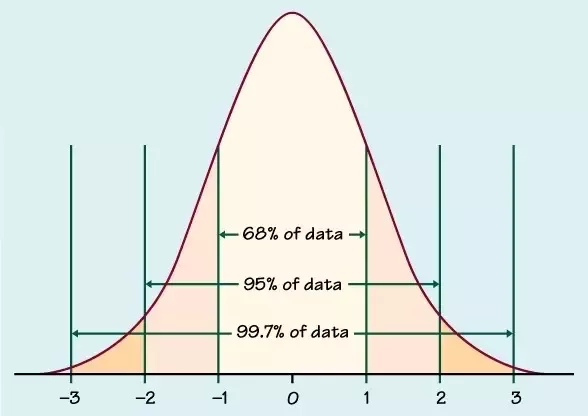

This method is good only for a normal distributed variabels.

#### Using median and Interquartile range (Boxplot)

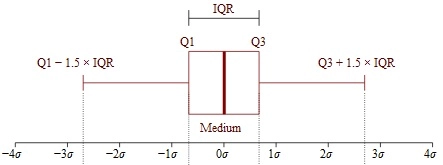

This method is good also to an unnormal distributed variabels.

In this artical, we checked each variable, one by one.
We started with identified univariate outliers in our data. As we so in the EDA chapter, according to the AD test, the only numerical variable which normally distributed is all_util. Therefore, in this work, we decided to use median and Interquartile range, as showed by Turkey (Tukey 1977), for all variables and the z score test only for all_util variable. That due to the fact that it is more robust to un-normal distribution.

<b> (1) loan amount 

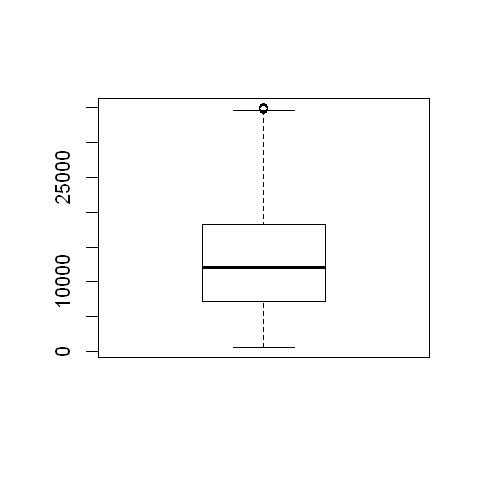

In [11]:
options(repr.plot.width = 4, repr.plot.height = 4)
plt1 <- boxplot(loans$loan_amnt)

we can see that most outliers are near the outliers boundary.

In [12]:
head(plt1$out,100)
length(plt1$out)

[1] 35000 35000 35000 35000 35000 35000 35000 35000 35000 35000 35000 35000
 [13] 35000 35000 35000 35000 35000 35000 35000 35000 35000 35000 35000 35000
 [25] 35000 35000 35000 35000 35000 35000 35000 35000 35000 35000 35000 35000
 [37] 35000 35000 35000 35000 35000 35000 35000 35000 35000 35000 35000 35000
 [49] 35000 35000 35000 35000 35000 35000 35000 35000 35000 35000 35000 35000
 [61] 35000 35000 35000 35000 35000 35000 35000 35000 35000 35000 35000 35000
 [73] 35000 35000 35000 35000 35000 35000 35000 35000 35000 35000 35000 35000
 [85] 35000 35000 35000 35000 35000 35000 35000 35000 35000 35000 35000 35000
 [97] 34800 35000 35000 35000

[1] 8084

We can see that most of the "outliers" getting the same value of 35000! Is there any value higher then 35000?


In [13]:
sum(plt1$out>35000)
sum(plt1$out==35000)
sum(plt1$out<35000)

[1] 0

[1] 8016

[1] 68

From the LC website, as of 2019:                            
<p><i>"Personal loans through LendingClub range from $1,000 to $40,000. The loan offer you receive is based upon what we believe is affordable for you, given the information on your application and credit report. As a marketplace, our goal is to ensure borrowers have a really good shot at successfully repaying their loans."

<b> Therefore, we can conclude that $ 35,000 is in the range of loans given by LC in past years and is not an error.
<p><b>For those reasons, we decided not to change those values.                                                                  <br>but label the loans with the maximum amount of 35000, for future work.



In [14]:
loans$max_L<-(loans$loan_amnt==35000)*1
bin_vars<-"max_L"

##### (2) funded_amnt

This parameter has a high correlation with "loan amount" and have very similar interpretation, so we expect to see results similar to the "loan amount" test.

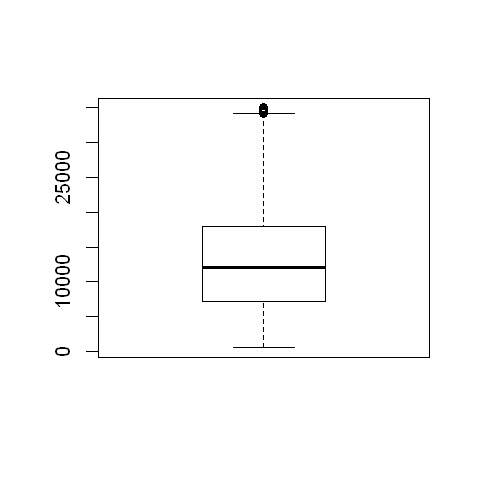

In [15]:
options(repr.plot.width = 4, repr.plot.height = 4)
plt2 <- boxplot(loans$funded_amnt)



we can see that there is  a lot of outliers just in the outliers border.

In [16]:

length(plt2$out)
sum(plt2$out>35000)
sum(plt2$out==35000)
sum(plt2$out<35000)

[1] 8129

[1] 0

[1] 7907

[1] 222

<b>Indeed, we can see that the results of testing this parameter are similar to Loan amount testing results and therefore our conclusion is the same.


In [17]:
loans$max_fund_L=(loans$funded_amnt==35000)*1
bin_vars<-c(bin_vars,"max_fund_L")

##### (3) funded_amnt_inv

This parameter has a high correlation with "loan amount" and "funded_amnt", so we expect to see results similar to the "loan amount" test.


[1] 35000 35000 35000 35000 35000 35000 35000 35000 35000 35000 35000 35000
[13] 35000 35000 35000 35000 35000 35000 35000 35000 35000 35000 35000 35000
[25] 35000 35000 35000 35000 35000 35000 35000 34675 35000 35000 35000 35000
[37] 35000 35000 35000 35000 35000 35000 35000 35000 35000 35000 35000 35000
[49] 35000 35000 35000 35000 35000 35000 35000 35000 35000 35000 35000 35000
[61] 35000 35000 35000 35000 35000 35000 35000 35000 35000 35000

[1] 8129

[1] 0

[1] 7907

[1] 222

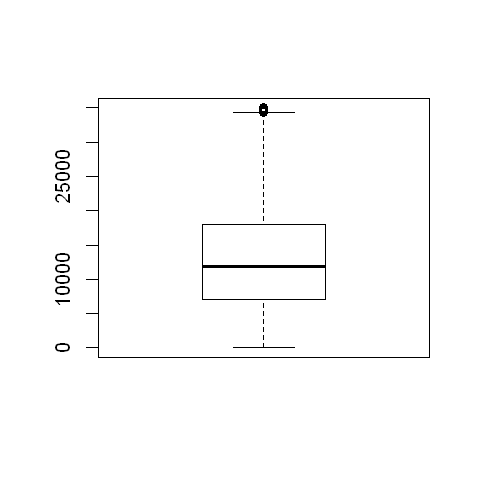

In [18]:
options(repr.plot.width = 4, repr.plot.height = 4)
plt3 <- boxplot(loans$funded_amnt_inv)
head((plt2$out),70)
length(plt2$out)
sum(plt2$out>35000)
sum(plt2$out==35000)
sum(plt2$out<35000)



Indeed, we can see that the results of testing this parameter are exactly  the same to funded_amnt testing results and therefore our conclusion is the same.




In [19]:
loans$MAX_fund_L_inv=(loans$funded_amnt==35000)*1
bin_vars<-c(bin_vars,"MAX_fund_L_inv")

<b> (4) loan_installment

In [20]:
head(loans$loan_installment, 40)

[1] 277.78 150.00  41.67 133.33 133.33 116.67 166.67 555.56 138.89 250.00
[11] 138.89 138.89  16.67 250.00 694.44 138.89 306.94 429.17  50.00 194.44
[21] 416.67 111.11 388.89  13.89 155.56  41.67 277.78 694.44 166.67  27.78
[31] 694.44  61.81 111.11  83.33 277.78 365.28 166.67 111.11 138.89 233.33

[1] 972.22 833.33 833.33 972.22 972.22 972.22 972.22 833.33 777.78 972.22
[11] 777.78 833.33 833.33 972.22 972.22 833.33 777.78 777.78 972.22 777.78
[21] 972.22 833.33 754.86 972.22 972.22 972.22 777.78 972.22 972.22 833.33
[31] 777.78 972.22 833.33 972.22 833.33 833.33 972.22 888.89 833.33 808.33
[41] 972.22 833.33 833.33 854.17 833.33 833.33 972.22 833.33 833.33 777.78
[51] 972.22 972.22 861.11 833.33 972.22 888.89 833.33 972.22 766.67 833.33
[61] 833.33 833.33 972.22 972.22 833.33 972.22 972.22 777.78 777.78 972.22

[1] 9824

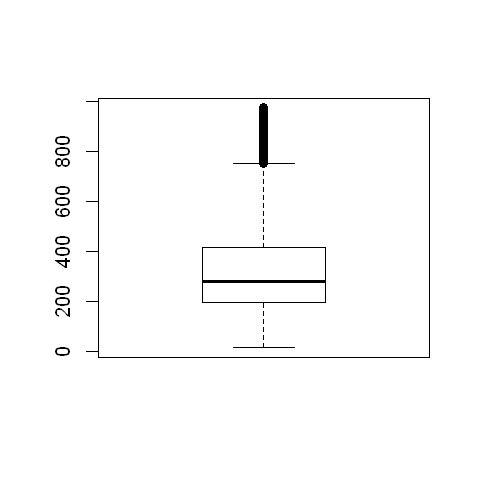

In [21]:
options(repr.plot.width = 4, repr.plot.height = 4)
plt4<- boxplot(loans$loan_installment)
head((plt4$out),70)
length(plt4$out)


[1] 972.22 972.22 972.22 972.22 972.22 972.22 972.22 972.22 972.22 972.22
[11] 972.22 972.22 972.22 972.22 972.22 972.22 972.22 972.22 888.89 972.22
[21] 972.22 972.22 972.22 972.22 888.89 972.22 972.22 972.22 972.22 972.22
[31] 972.22 972.22 972.22 972.22 972.22 972.22 972.22 972.22 972.22 972.22
[41] 972.22 972.22 972.22 972.22 972.22 888.89 972.22 972.22 944.44 972.22
[51] 972.22 972.22 972.22 888.89 972.22 972.22 972.22 972.22 972.22 972.22
[61] 972.22 869.44 972.22 972.22 972.22 972.22 972.22 972.22 972.22 972.22

[1] 4997

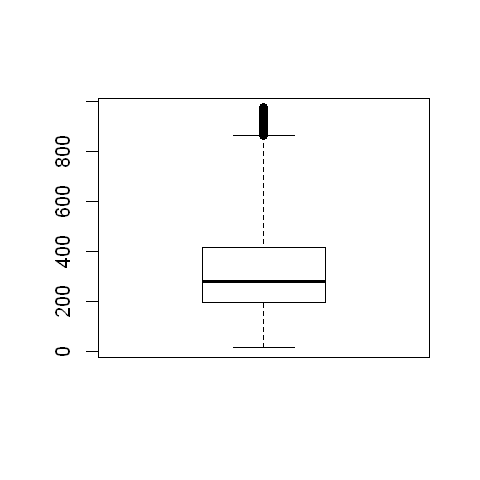

In [22]:
options(repr.plot.width = 4, repr.plot.height = 4)
plt4.1<- boxplot(loans$loan_installment, range = 2)
head((plt4.1$out),70)
length(plt4.1$out)


In [23]:
sum(plt4.1$out==972.22)

[1] 3823

The installment parameter is an outcome of two other parameters interaction: loan term and loan amount.
There is just two loan terms available, 36 months and 64 months.
We have to remember that 972.22 is just the outcome of 35,000/36 and we decide to not call 35000 loan amount an outlier.

In order to make a decision more carefully, let's look on the different loan amount in different term.


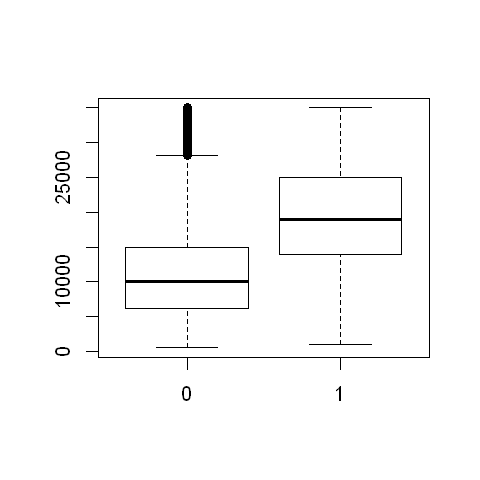

In [24]:

plt4.2<-boxplot(loans$loan_amnt~loans$term) 


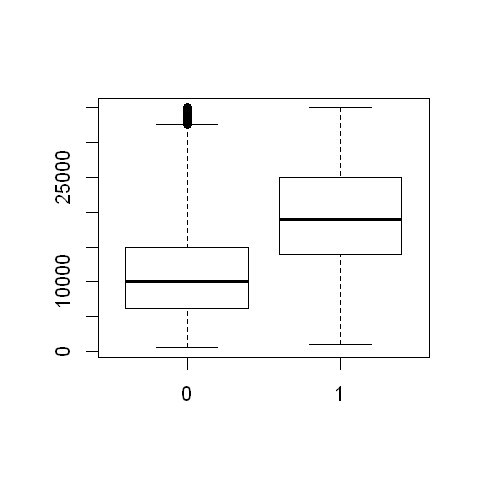

In [25]:
plt4.3<-boxplot(loans$loan_amnt~loans$term,range=2) 

Distinguished by term, all of the loan amount outliers are in the 36 term.

In [26]:
out4.2<-plt4.2$out
length(out4.2)
head(out4.2)
sum(out4.2==35000)
min(out4.2)


[1] 7649

[1] 35000 30000 30000 35000 35000 35000

[1] 3823

[1] 28225

Approximately half of the outliers are not equal to the maximum loan amount.


<b>(5)  mths_since_last_major_derog

A count variable

[1] 148 116 116 152 122 113 115 120 134 141 131 119 122 152 139 114 133 119 112
[20] 113 119 112 123 142 122 119 142 119 114 122 112 114 120 142 123 140 120 114
[39] 118 151 130 122 117 125 118 136 137 120 119 124 118 127 125 150 112 114 134
[58] 130 114 124 118 133 132 128 120 134 126 137 115 112

[1] 155

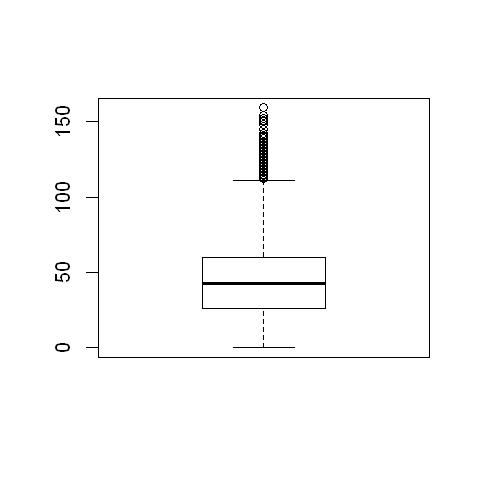

In [27]:
options(repr.plot.width = 4, repr.plot.height = 4)
plt5<- boxplot(loans$mths_since_last_major_derog)

head((plt5$out),70)
length(plt5$out)

In [28]:
min(plt5$out)
plt5$stats
max(plt5$out)

[1] 112

[,1]
[1,]    0
[2,]   26
[3,]   43
[4,]   60
[5,]  111
attr(,"class")
        1 
"integer"

[1] 159

In [29]:
159/12

[1] 13.25

159 month since the last derog is sound reasonable

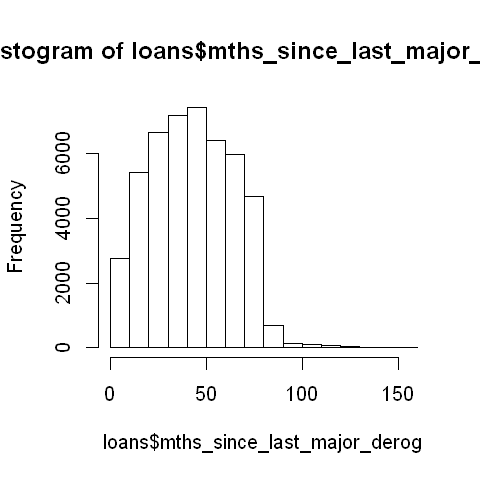

In [30]:
hist(loans$mths_since_last_major_derog)

We can see that to the mths_sine_las_major thare is a long tale distrabution. 


<b>(6) annual_inc [annual_inc_log, annual_inc_rt]

[1] 350000 300000 616000 165000 270000 500000 616000 185000 264000 214000
[11] 213000 300000 200000 225000 180000 250000 320000 276000 170000 276000
[21] 180000 200000 200000 275000 165000 220000 250000 480000 200000 175000
[31] 153000 180000 173000 180000 225000 375000 165000 155000 200600 160000
[41] 189500 572400 151800 175000 350000 178000 200000 220000 160000 220000
[51] 163900 200000 180000 200000 156000 160000 202000 155000 225000 151000
[61] 182500 374000 175000 234000 178364 160000 322008 225000 155000 200000

[1] 10721

1896
45000
62000
87000
150000


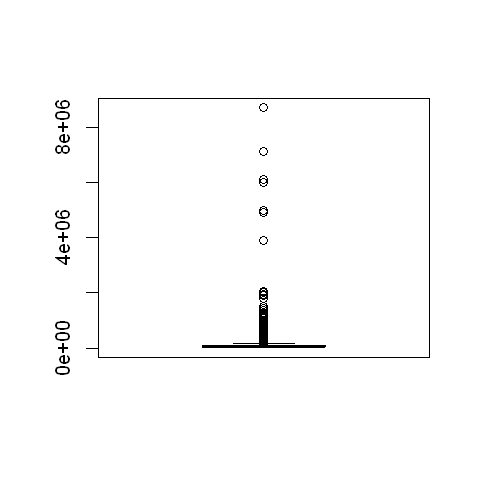

In [31]:
options(repr.plot.width = 4, repr.plot.height = 4)
plt6<- boxplot(loans$annual_inc)
head((plt6$out),70)
length(plt6$out)
plt6$stats

In [32]:
min(plt6$out)


[1] 150060

In [33]:
quantile(x = loans$annual_inc, na.rm = TRUE)

0%     25%     50%     75%    100% 
   1896   45000   62000   87000 8706582

<b>It is look like there is a lot of outliers, but from this boxplot and from the EDA stage, we can remember</b> 
<br>that this variable is distributed exponentially. 
<br>In the feature engineering stage we did transform this variable with a log function. 
<br>now we will check the log transformation influence on the outliers detection process


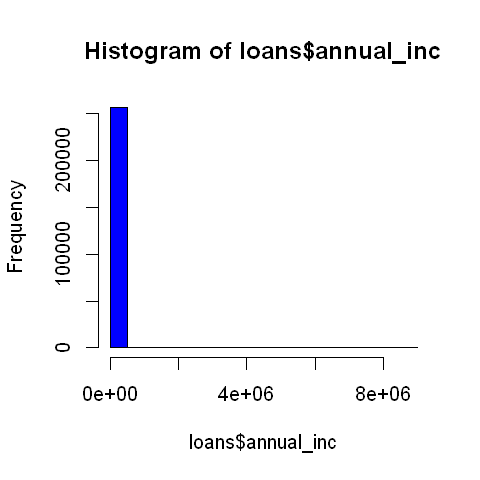

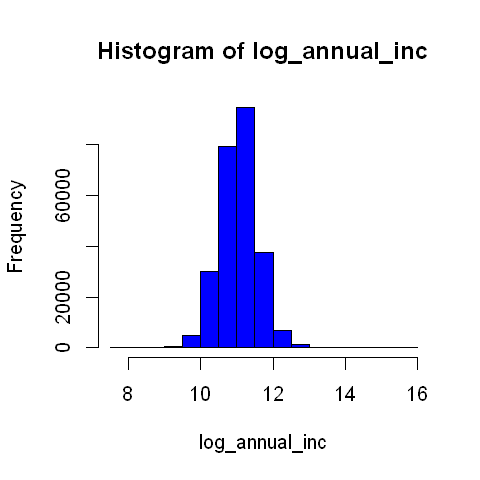

In [34]:
e <- exp(1) 
log_annual_inc<-log(loans$annual_inc,base = e )
hist(loans$annual_inc,col = 20)
hist(log_annual_inc,col = 20)

[1] 4582

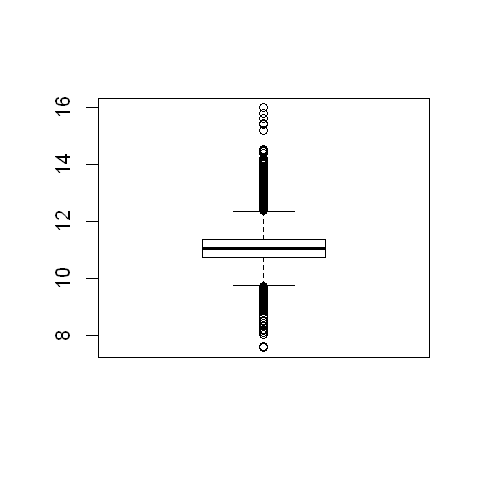

In [35]:
plt6_l<- boxplot(log(loans$annual_inc,base = e))
length(plt6_l$out)

The outliers number is decrees dramatically, as consequence of the log transformation.

We also can see that there are very far outliers. What is there values? 

In [36]:
max(loans$annual_inc,na.rm = TRUE)


[1] 8706582

the maximum annual inc is 870,6582 dollars. Is it a mistake? 
<br> According to the cnbc ,based on the IRS, $480,930, makes you one of the 1% high income in the US.
<br>https://www.cnbc.com/2018/07/10/heres-how-much-money-the-1-percent-really-make.html
<br> According to Wikipedia, as 3% presents of households in the USA have an annual inc over 200,000 dollars
<br>and two working individuals in a mean household.
<br>https://en.wikipedia.org/wiki/Household_income_in_the_United_States
 


In [37]:
sum(loans$annual_inc>200000,na.rm = TRUE)/sum(loans$annual_inc<10000000000,na.rm = TRUE)

[1] 0.0156971

In [38]:
sum(loans$annual_inc>480930,na.rm = TRUE)/sum(loans$annual_inc<10000000000,na.rm = TRUE)

[1] 0.001231835

In [39]:
sum(loans$annual_inc>1000000,na.rm = TRUE) 
sum(loans$annual_inc>4000000,na.rm = TRUE)
sum(loans$annual_inc>6000000,na.rm = TRUE)

[1] 35

[1] 7

[1] 3

<b>We can see that in our data set the percentage of the high salary individuals is less than  general, which make sense.
 <br> we did labeled the loans took by high income individuals as part of the feature engineering stage.


<b>(7) dti

[1] 39.43 38.98 39.72 38.90 38.93 39.11 39.16 39.17 39.82 39.41 39.47 38.98
[13] 38.94 39.45 38.88 39.88 39.62 39.57 39.15 38.94 39.72 39.81 39.70 39.59
[25] 38.91 39.87 38.87 39.70 39.07 39.52 39.60 39.07 38.96 39.86 39.41 39.00
[37] 39.63 39.78 39.82 39.17 38.84 39.08 39.53 39.53 39.99 39.05 39.70 39.76
[49] 39.31 39.50 39.28 39.43 39.89 38.87 39.76 38.88 39.66 39.70 39.60 39.06
[61] 38.87 39.75 39.75 39.26 39.52 38.98 39.85 39.06 39.48 39.55

[1] 295

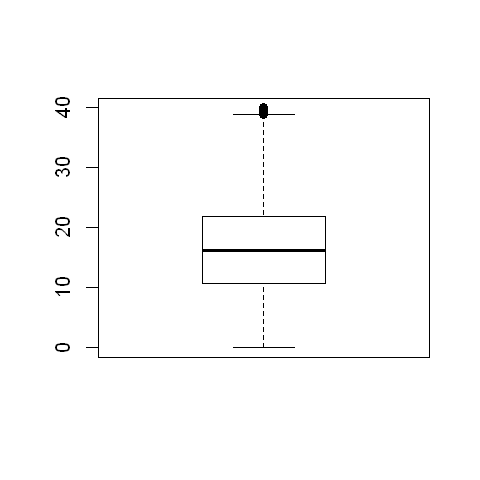

In [40]:
options(repr.plot.width = 4, repr.plot.height = 4)
plt7<- boxplot(loans$dti)

head((plt7$out),70)
length(plt7$out)

In [41]:
min(plt7$out)
quantile(x = loans$dti)

[1] 38.84

0%   25%   50%   75%  100% 
 0.00 10.73 16.18 21.97 39.99

[1] 39.99 39.96 39.98 39.98 39.99 39.97 39.97

[1] 7

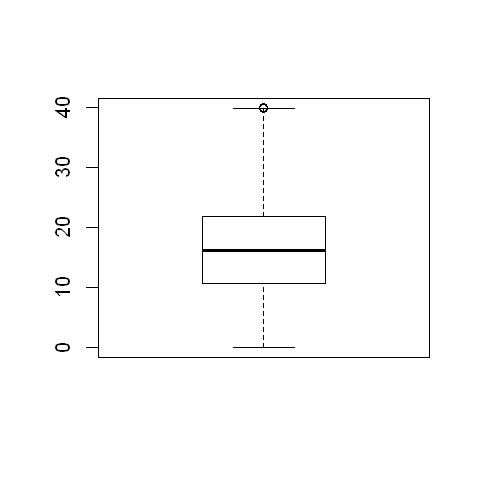

numeric(0)

[1] 0

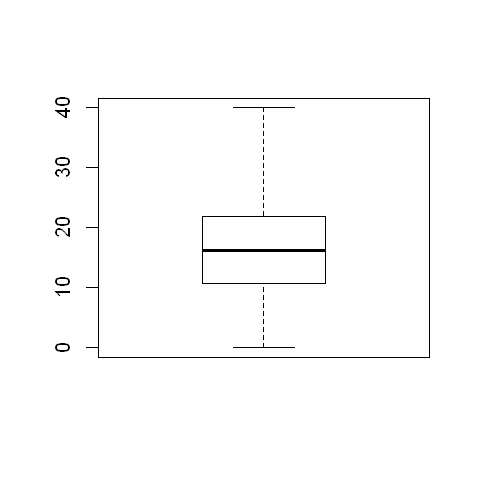

In [42]:
options(repr.plot.width = 4, repr.plot.height = 4)
plt16.1<- boxplot(loans$dti,range = 1.6)

head((plt16.1$out),70)
length(plt16.1$out)

plt16.1<- boxplot(loans$dti,range = 1.61)

head((plt16.1$out),70)
length(plt16.1$out)


We can see that most outliers are near the outlier's boundary, and all
<br> of them are<b> less than 40. </b>
<br>From LC web site we can study that 40 is the higher boundery of this:
<br>"Ideally, your debt-to-income ratio would be lower than 40%. That’s generally the threshold used across the industry. If your DTI is <br>higher than 40%, your loan application will likely be denied."


<b>(8) delinq_2yrs [cat_delinq_2yrs]


A count variable

[1]  1  1  3  1  1  2  2  2  2  1  1  4  2  1  1  1  1 13  2  1  1  1  1  1  1
[26]  1  2  1  2  1  6  2  4  1  4  1  1  1  1  4  1  2  1  3  1  3  1  1  1  2
[51]  1  1  1  1  2  1  1  2  1  1  1  2  1  1  1  2  1  3  1  1

[1] 41148

[,1]
[1,]    0
[2,]    0
[3,]    0
[4,]    0
[5,]    0
attr(,"class")
        1 
"integer"

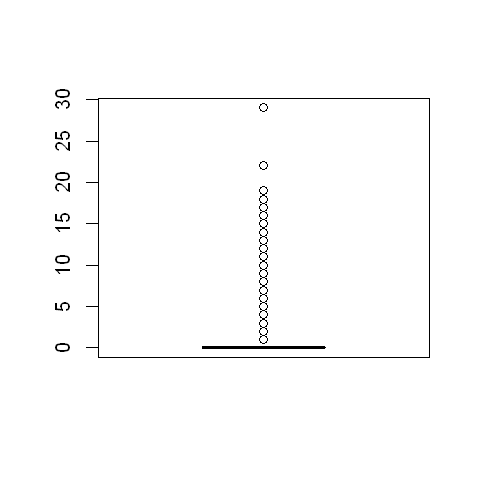

In [43]:
options(repr.plot.width = 4, repr.plot.height = 4)
plt8<- boxplot(loans$delinq_2yrs)

head((plt8$out),70)
length(plt8$out)
plt8$stats

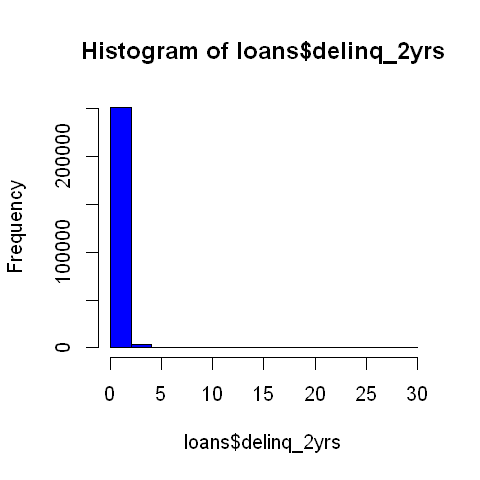

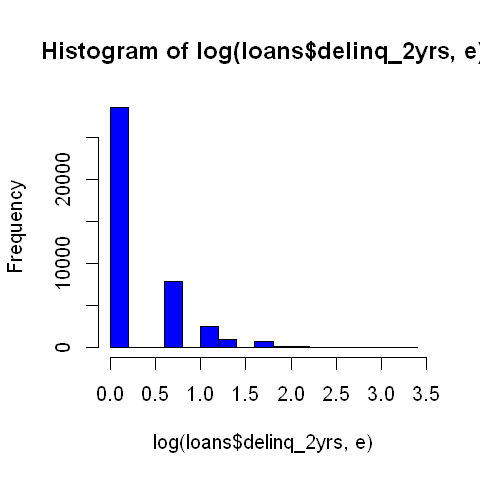

In [44]:
hist(loans$delinq_2yrs,col = 20)
hist(log(loans$delinq_2yrs,e),col = 20)

In [45]:
min(loans$delinq_2yrs,  na.rm=TRUE)
quantile(x = loans$delinq_2yrs, na.rm=TRUE)
sum(loans$delinq_2yrs==0,  na.rm=TRUE)
sum(loans$delinq_2yrs!=0,  na.rm=TRUE)

[1] 0

0%  25%  50%  75% 100% 
   0    0    0    0   29

[1] 214543

[1] 41148

Most of the values are equal to zero, and all the 41148 outliers are the values that are differ from zero.
Therefore, for now, we decided mark all the number that are differ from zero.
<b>It is seems that is better to treat that count variable as categorical variable.


<b>(9) acc_now_delinq

A count variable

[1] 739

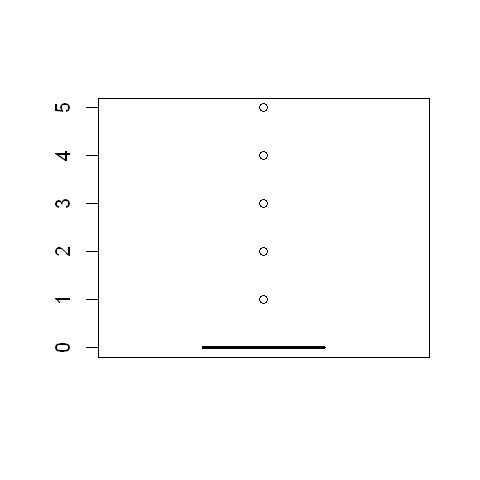

In [46]:
plt8<-boxplot(loans$acc_now_delinq)
length(plt8$out)

In [47]:

quantile(x = loans$acc_now_delinq, na.rm=TRUE)
sum(loans$acc_now_delinq==0,  na.rm=TRUE)
sum(loans$acc_now_delinq!=0,  na.rm=TRUE)


0%  25%  50%  75% 100% 
   0    0    0    0    5

[1] 254952

[1] 739

most of the values are equal to zero, and all the 739 outliers are the values that are differ from zero. Therfore, for now, we dicided to mark all the number that are differ from zero.
<br><b>It is seems that is better to treat that variable as categorical variable.

In [48]:
loans$is_acc_now_delinq_not_zero<-(loans$acc_now_delinq!=0)*1
bin_vars<-c(bin_vars,"is_acc_now_delinq_not_zero")

<b>(10) inq_last_6mths [cat_inq_last_6mths]

A count variable

[1]  4  3  9 11 18  3  3 10  3  8  6 14 28  4 31  3  8  3  3  5  7  4  3  4  7
[26]  4 12  5  4  5  8  3  8  3  5  5  6  3  7 16  6  6  8  6  3  6  6  4  3  3
[51]  3  4 10  5  6  7 25  4 16  4  5  6 15  3  3  3  3 12  5 20

[1] 23682

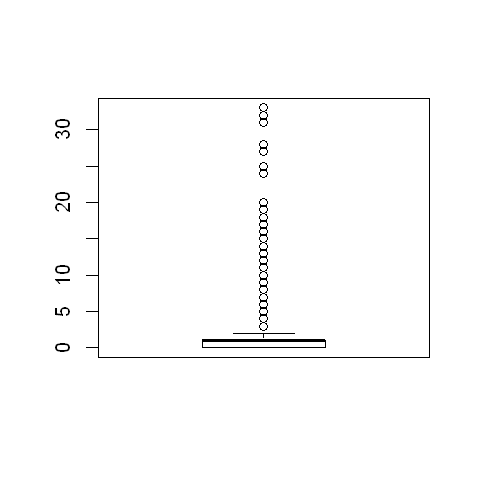

In [49]:
options(repr.plot.width = 4, repr.plot.height = 4)
plt9<- boxplot(loans$inq_last_6mths)

head((plt9$out),70)
length(plt9$out)

In [50]:
max((plt9$out))
sum(loans$inq_last_6mths==0,na.rm = TRUE)
sum(loans$inq_last_6mths!=0,na.rm = TRUE)

[1] 33

[1] 124083

[1] 131608

About as half of values are  zero

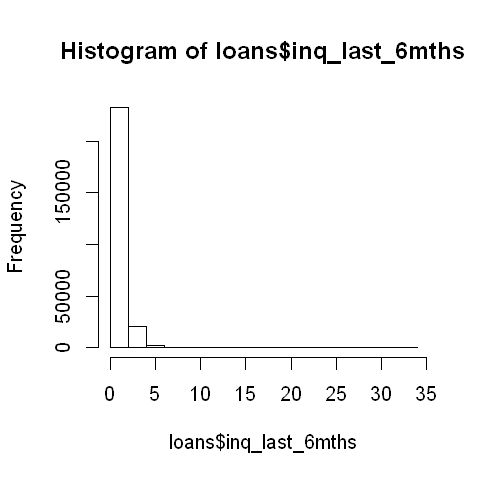

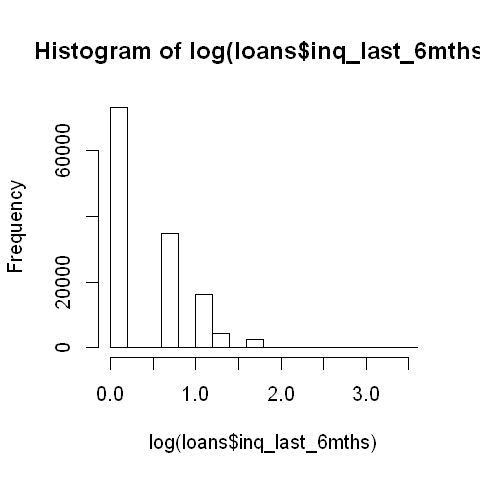

In [51]:
hist(loans$inq_last_6mths)
hist(log(loans$inq_last_6mths))


It is seems that is better to treat that variable as categorical variable. 
As we did on feature engineering notebook

<b>(11) mths_since_last_delinq [mths_since_last_delinq_rt]

A count variable

[1] 103 107 120 106 115 148 116 108 152 122 113 120 134 141 110 131 122 106 109
[20] 139 133 104 106 140 151 130 107 104 131 135 104 131 108 106 112 114

[1] 36

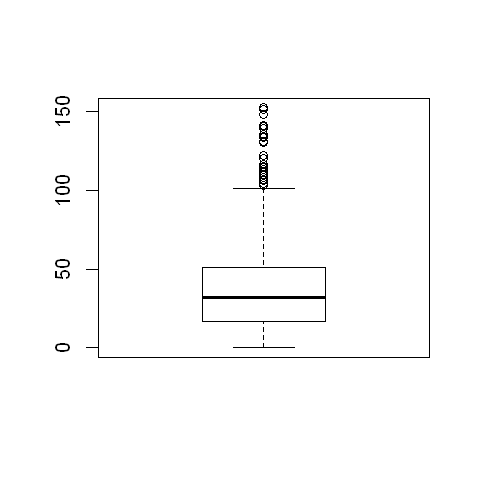

In [52]:
options(repr.plot.width = 4, repr.plot.height = 4)
plt10<- boxplot(loans$mths_since_last_delinq)

head((plt10$out),70)
length(plt10$out)

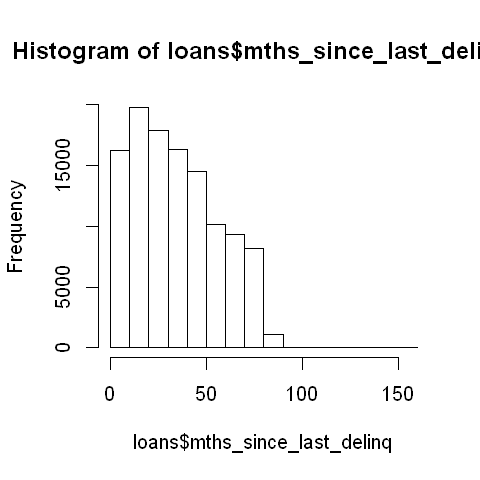

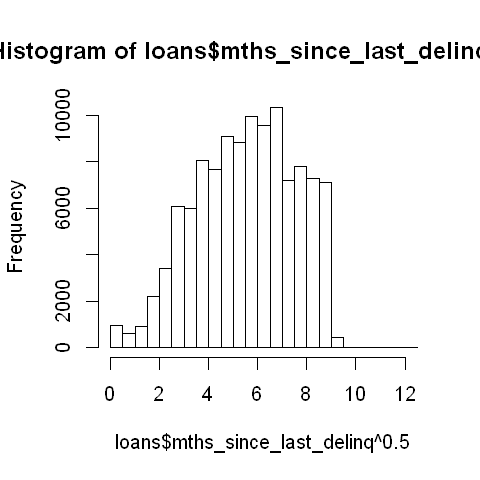

In [53]:
hist(loans$mths_since_last_delinq)
hist(loans$mths_since_last_delinq^0.5)


[1] 12.16553 12.32883 11.87434 11.78983 11.83216 12.28821

[1] 6

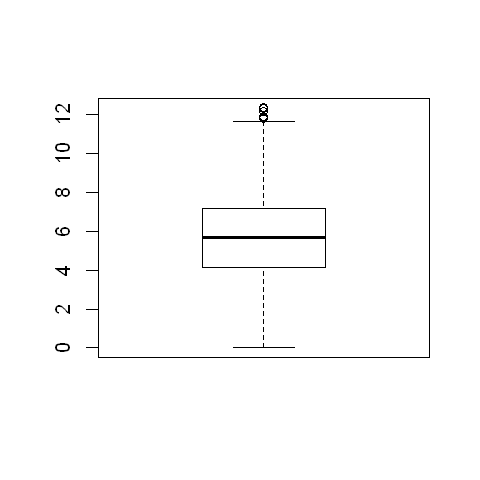

In [54]:
plt10<- boxplot(loans$mths_since_last_delinq^0.5)

head((plt10$out),70)
length(plt10$out)

The outliers number is decrees dramatically, as consequence of the root transformation.

<b>(12) mths_since_last_record

A count variable

numeric(0)

[1] 0

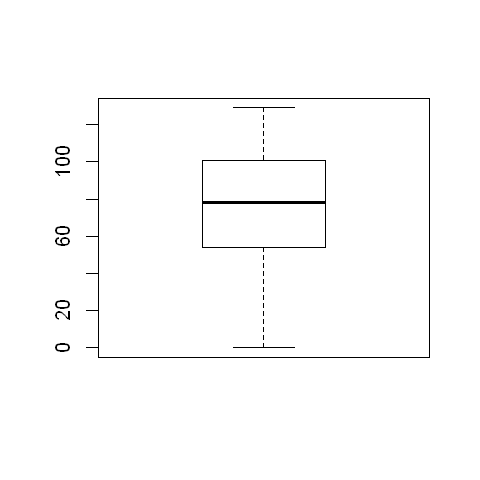

In [55]:
options(repr.plot.width = 4, repr.plot.height = 4)
plt11<- boxplot(loans$mths_since_last_record)

head((plt11$out),70)
length(plt11$out)

there is no outliers probably because there is alot of NAs

<b>(13) open_acc [open_acc_rt]

[1] 28 29 28 26 27 33 31 35 31 42 27 25 47 27 37 31 28 25 26 26 32 27 25 29 31
[26] 46 31 41 27 25 25 32 28 29 30 25 28 26 25 29 30 29 31 30 30 28 25 34 35 44
[51] 30 27 25 28 26 25 25 25 26 26 27 27 28 29 25 25 32 27 27 27

[1] 3712

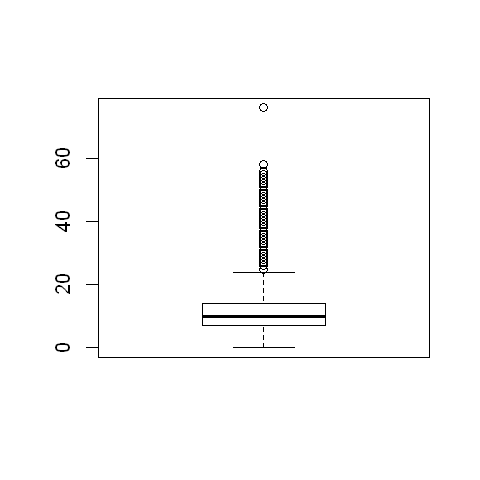

In [56]:
options(repr.plot.width = 4, repr.plot.height = 4)
plt12<- boxplot(loans$open_acc)

head((plt12$out),70)
length(plt12$out)

In [57]:
max(plt12$out)

[1] 76

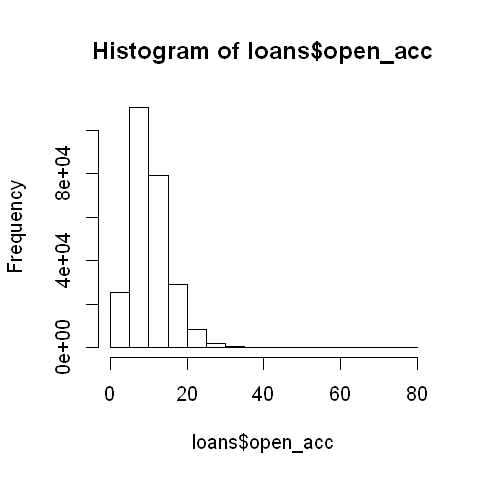

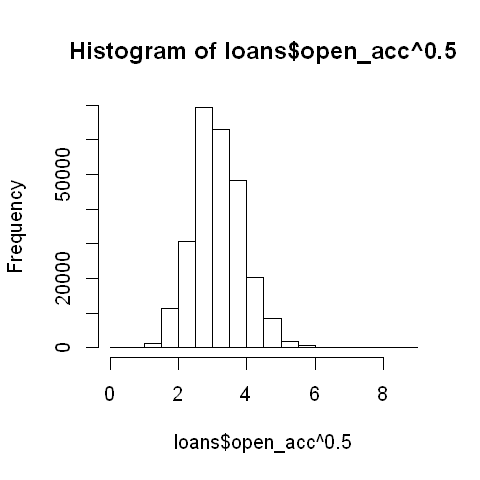

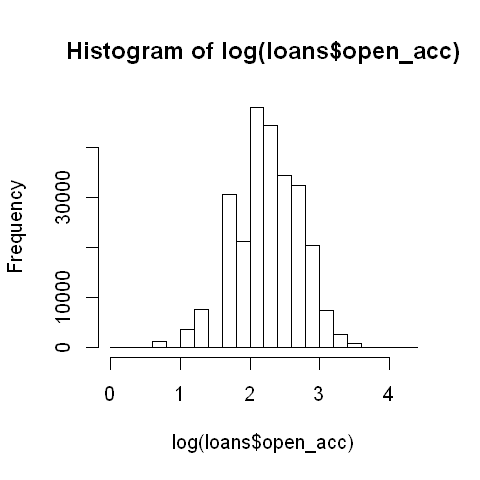

In [58]:
hist(loans$open_acc)
hist(loans$open_acc^0.5)
hist(log(loans$open_acc))

[1] 1134

Warning message in bplt(at[i], wid = width[i], stats = z$stats[, i], out = z$out[z$group == :
"Outlier (-Inf) in boxplot 1 is not drawn"

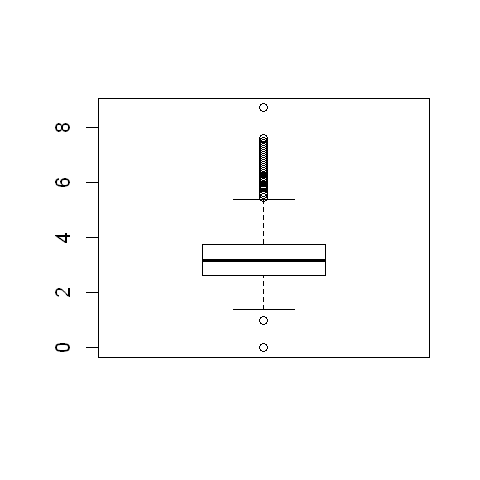

[1] 1501

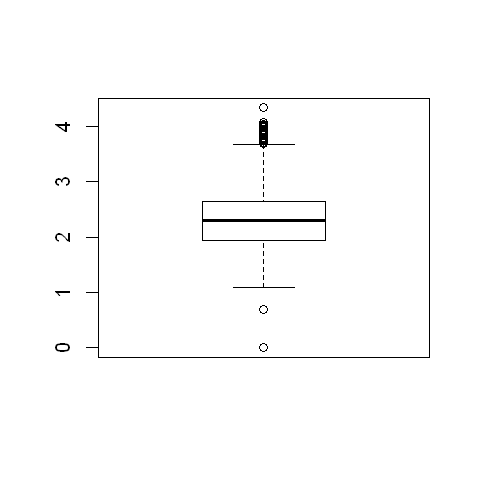

In [59]:
rootb9<-boxplot(loans$open_acc^0.5)
length(rootb9$out)
logb9<-boxplot(log(loans$open_acc))
length(logb9$out)

The outliers number is decrees dramatically, as consequence of both the root transformation and the log transformation.

<b>(14) revol_bal [ revol_bal_rt]

[1] 128850  44827  66033 150786 150786  46525  41674  51914  62739 121719
[11] 107007 128000 168496  43039 148829 245886  43302  56411  81695  68438
[21]  85607  40598 107501  40384  40384 222702  60134 401941 407794 275925
[31]  66654  52316 216959  53670 275925  72303  61921  40238  81617  81330
[41]  51761  56740  55720 130799  69407  48251  74292  57196  40934  78203
[51]  60568  64851  45623  51489  46670 133963 204954  40726  47039  91557
[61]  42703  42619  52201 150971 238903  39486  55188  69909  76428 117814

[1] 13406

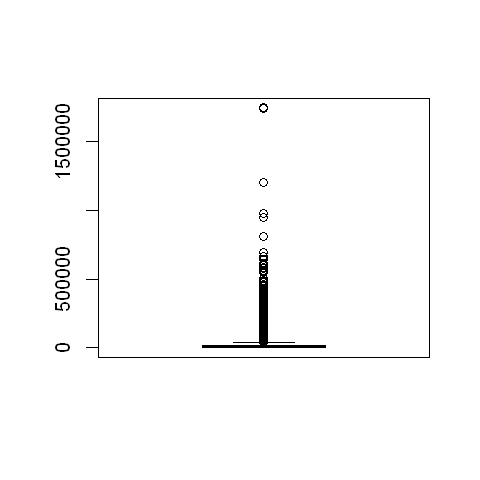

In [60]:
options(repr.plot.width = 4, repr.plot.height = 4)
plt13<- boxplot(loans$revol_bal)

head((plt13$out),70)
length(plt13$out)

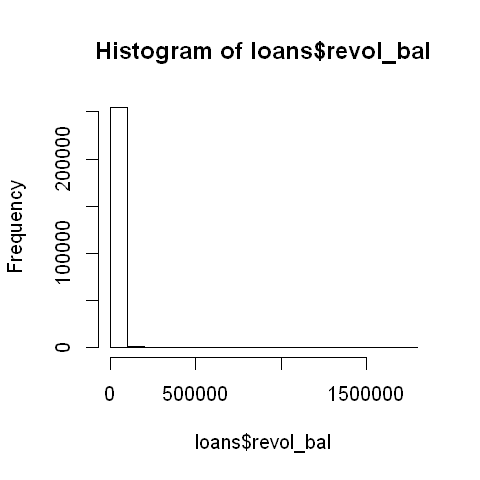

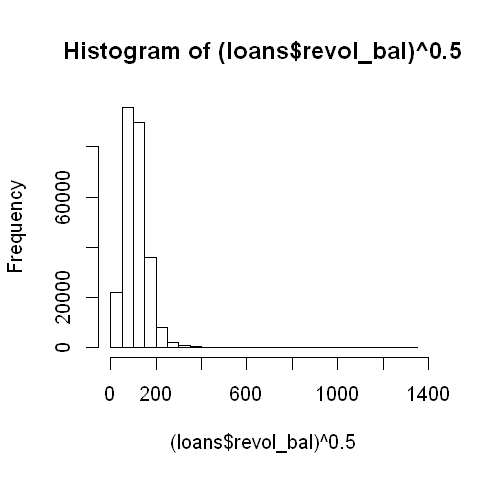

In [61]:
hist(loans$revol_bal)

hist((loans$revol_bal)^0.5)

[1] 358.9568 256.9689 388.3117 388.3117 250.4775 348.8825 327.1192 357.7709
 [9] 410.4826 385.7836 495.8689 237.5100 285.8234 261.6066 292.5867 327.8735
[17] 471.9131 245.2223 633.9882 638.5875 525.2856 258.1744 465.7886 231.6679
[25] 525.2856 268.8922 248.8393 285.6869 285.1842 238.2016 236.0508 361.6614
[33] 263.4521 272.5656 239.1569 279.6480 246.1057 254.6586 366.0096 452.7185
[41] 302.5839 388.5499 488.7770 234.9213 264.4031 276.4561 343.2404 290.2344
[49] 387.7293 264.4560 281.7712 237.6573 297.0236 401.6678 265.8665 385.4089
[57] 283.7076 293.9881 254.4072 265.5805 261.6849 520.3845 375.7193 436.4470
[65] 434.5734 497.9659 338.4021 243.1173 299.9200 308.7977

[1] 6119

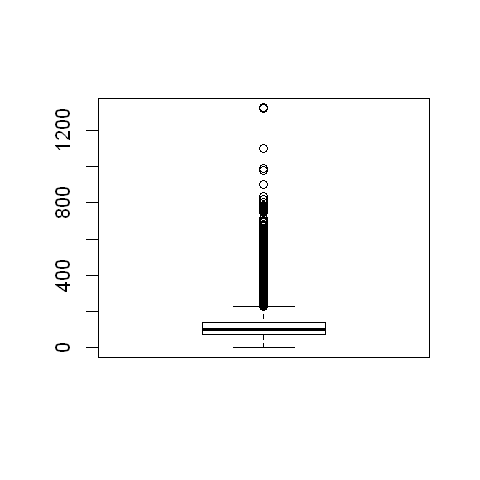

In [62]:
plt13<- boxplot(loans$revol_bal^0.5)

head((plt13$out),70)
length(plt13$out)

The outliers number did decrees, as consequence of both the root transformation.

<b>(15) revol_util

[1] 150.7 892.3 146.1 153.0

[1] 4

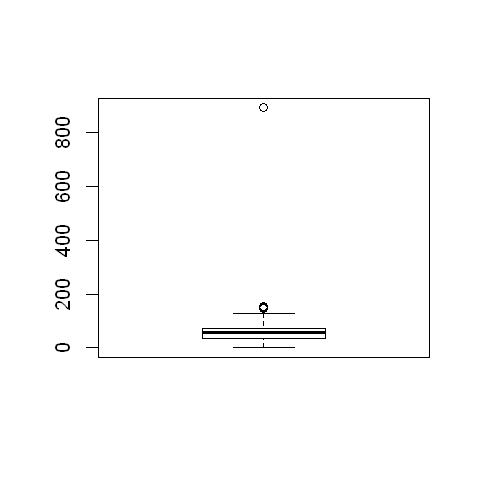

In [63]:
options(repr.plot.width = 4, repr.plot.height = 4)
plt14<- boxplot(loans$revol_util)

head((plt14$out),70)
length(plt14$out)

In [64]:
plt14$stats

0.0
36.2
55.8
73.9
129.4


there is only 4 outliers but just one oulaier is very far from the others.
<br>it is interesting to find what loan is it?

In [65]:
max(loans$revol_util, na.rm=TRUE)

[1] 892.3

<br>As noted in previous notebooks, this variable is a rate representing the amount of the credit line 
<br> used relative to total credit available.


In [66]:
sum(100>loans$revol_util, na.rm=TRUE)
sum(100<loans$revol_util, na.rm=TRUE)

[1] 254854

[1] 587

As accpected, most of the loans revol_util rates are less than 100.
<br> what makes some revol_util rates to be more than an 100?
<br> how peaple can borrow more than thar credit line?
<br> Sopraisly, We found avidence that the answer is yes!
<br>https://www.thebalance.com/can-you-go-over-your-credit-limit-961095
<br>https://www.creditcards.com/credit-card-news/credit-limit-how-far-over-before-card-declined.php
<br>https://www.valuepenguin.com/what-happens-if-you-go-over-your-credit-limit


In [67]:
max(loans$revol_util[loans$revol_util!=max(loans$revol_util, na.rm=TRUE)], na.rm=TRUE)

[1] 153

In [68]:

Lmax<-loans[loans$revol_util==max(plt14$out),]
Lmax[!is.na(Lmax$verification_status),]

,verification_status,issue_d,pymnt_plan,purpose,initial_list_status,emp_length,loan_amnt,funded_amnt,funded_amnt_inv,term,...,annual_inc_rt,inc_grp,revol_bal_rt,credit_hist_log,credit_hist_rt,credit_hist_grp,max_L,max_fund_L,MAX_fund_L_inv,is_acc_now_delinq_not_zero
170687,Verified,2014-04-01,0,debt_consolidation,1,10+ years,3500,3500,3500,0,...,212.132,verylow_inc,51.73973,2.890372,4.242641,17-21_yrs,0,0,0,0


In [69]:
892.3/2677

[1] 0.3333209

this value is very far from other values, while the other characters of the loan looks like a regular loan.
<br>The revol_bal is 2677, Total revolving high credit/credit limit is 300.


In [70]:
2677/300

[1] 8.923333

<br> If this is an error it resulting from the revoll bal or from revoll_util and not from errors in calculations.
<br> As we didn't find sufficient proof for an error, but we decided to keep this value.

<b>(16) total_acc

A count variable

[1] 63 61 60 63 57 61 76 57 61 63 62 61 63 63 59 61 63 59 73 60 60 63 62 68 59
[26] 64 59 62 63 60 63 61 57 58 58 57 59 61 61 67 62 59 63 63 63 69 58 58 60 65
[51] 63 58 59 58 65 62 62 58 62 63 62 60 58 63 63 63 63 63 60 63

[1] 3895

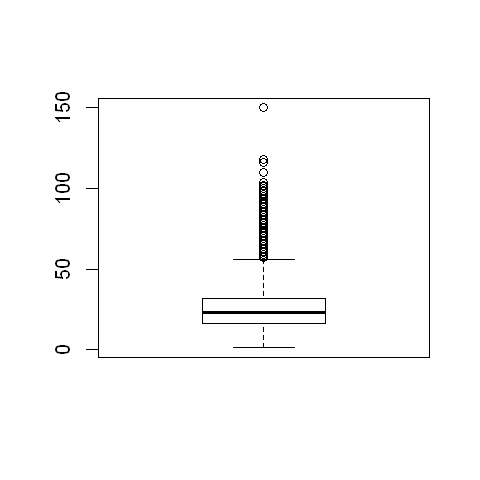

In [71]:
options(repr.plot.width = 4, repr.plot.height = 4)
plt15<- boxplot(loans$total_acc)

head((plt15$out),70)
length(plt15$out)

The total number of credit lines currently in the borrower’s credit file

In [72]:
Lmax<-loans[loans$total_acc==max(plt15$out),]
Lmax[!is.na(Lmax$total_acc),]

,verification_status,issue_d,pymnt_plan,purpose,initial_list_status,emp_length,loan_amnt,funded_amnt,funded_amnt_inv,term,...,annual_inc_rt,inc_grp,revol_bal_rt,credit_hist_log,credit_hist_rt,credit_hist_grp,max_L,max_fund_L,MAX_fund_L_inv,is_acc_now_delinq_not_zero
176253,Verified,2014-12-01,0,home_improvement,1,10+ years,35000,35000,35000,0,...,434.7413,veryhigh_inc,197.6487,3.295837,5.196152,>21_yrs,1,1,1,0


<b>(17) tot_coll_amt

[1]  717   75   84  205 1779   50  740  125  362  329  790   75  576  110  120
[16] 9180 5562  294   62  125  290  188   88  104  117  512  351  204   94  563
[31] 1186  249  152  102  161  110  573  178   72   55  240  119  971  140  762
[46]  325  669  143  139   81 1108  462  410  171 1546  170 1575  395  903  108
[61]   93  410  265  608   99  283  320  516  118  763

[1] 21706

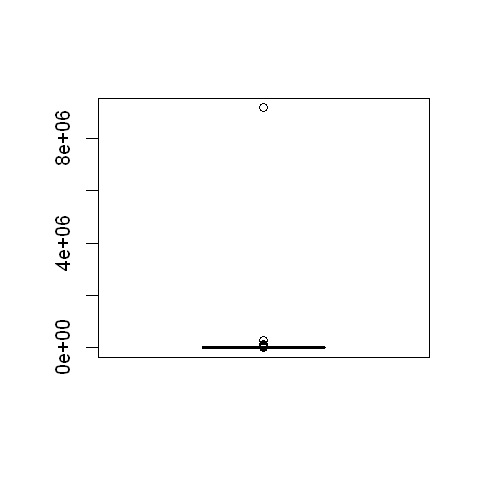

In [73]:
options(repr.plot.width = 4, repr.plot.height = 4)
plt16<- boxplot(loans$tot_coll_amt)

head((plt16$out),70)
length(plt16$out)

In [74]:
m1<-max(plt16$out)
m2<-max( plt16$out[plt16$out!=max(plt16$out)] )
m1
m2
m1/m2

[1] 9152545

[1] 296368

[1] 30.88237

Over than 9 milion dollars supposedly collected from this borrower over 
<br>all times, that is 30 times more than the second high amount collected!
<br>who is this individual?

In [75]:

Lmax<-loans[loans$tot_coll_amt==max(plt16$out),]
print(Lmax[!is.na(Lmax$tot_coll_amt),])

       verification_status    issue_d pymnt_plan purpose initial_list_status
190946            Verified 2014-04-01          0   other                   0
       emp_length loan_amnt funded_amnt funded_amnt_inv term
190946     1 year     10800       10800           10800    0
       collections_12_mths_ex_med mths_since_last_major_derog home_ownership
190946                          0                          46       MORTGAGE
       annual_inc dti delinq_2yrs acc_now_delinq inq_last_6mths
190946     122000 9.1           0              0              1
       mths_since_last_delinq mths_since_last_record open_acc pub_rec revol_bal
190946                     46                     NA        8       0      4742
       revol_util total_acc tot_coll_amt tot_cur_bal open_acc_6m open_il_6m
190946       34.9        34      9152545      233924          NA         NA
       open_il_12m open_il_24m mths_since_rcnt_il total_bal_il il_util
190946          NA          NA                 NA          

<b>This person have a low dti, nice but not very high annual income  and a mortgage.
<br>For a person that dont own a home and is annual inc less than 150,000 $, more than 9 milion dollars paid in the past looks
<br> seems unreasonable!
<br>Therefore, it was reasonable for us to assume that this outlaier is an outcome of an error. </b>
<br>and we raplaced it with a NA.

In [76]:
loans$tot_coll_amt[loans$tot_coll_amt==max(plt16$out)]<-NA

[1]  717   75   84  205 1779   50  740  125  362  329  790   75  576  110  120
[16] 9180 5562  294   62  125  290  188   88  104  117  512  351  204   94  563
[31] 1186  249  152  102  161  110  573  178   72   55  240  119  971  140  762
[46]  325  669  143  139   81 1108  462  410  171 1546  170 1575  395  903  108
[61]   93  410  265  608   99  283  320  516  118  763

[1] 21705

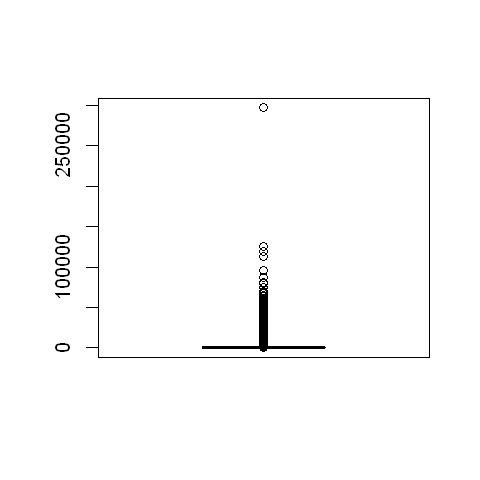

In [77]:
options(repr.plot.width = 4, repr.plot.height = 4)
plt16<- boxplot(loans$tot_coll_amt)

head((plt16$out),70)
length(plt16$out)

<b>(18) tot_cur_bal

[1]  682908  659155  615008  502813  531101  652656  481466  558792  515427
[10]  497258  885804  499076  583902  744471  618450  961869  846513  584781
[19] 1787296  577700  510603  661680  522386  564844  548739  577510  786999
[28]  590741  491085  550257  573076  774901  492773  498809  775797  491592
[37]  518071  941666  525908  554250  501293  558010  484915  886561  501031
[46]  502403  832118  526591  746743  589307  608197  505219  722310  529658
[55]  624709  591017  571924  484751  609999  596157  562776  540227  495546
[64]  498343  498055  535359  908732  517111  532626  800369

[1] 5910

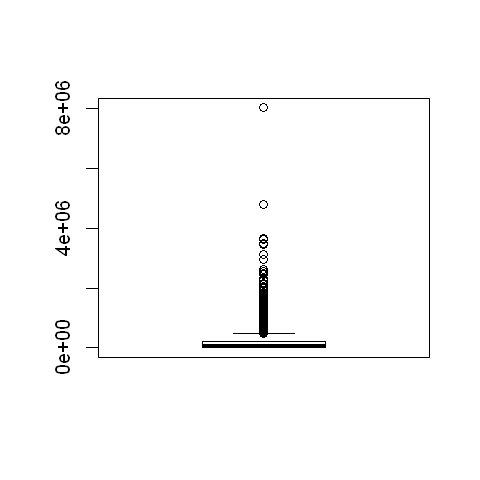

In [78]:
options(repr.plot.width = 4, repr.plot.height = 4)
plt17<- boxplot(loans$tot_cur_bal)

head((plt17$out),70)
length(plt17$out)

In [79]:
min(loans$tot_cur_bal,na.rm=TRUE) 

[1] 0

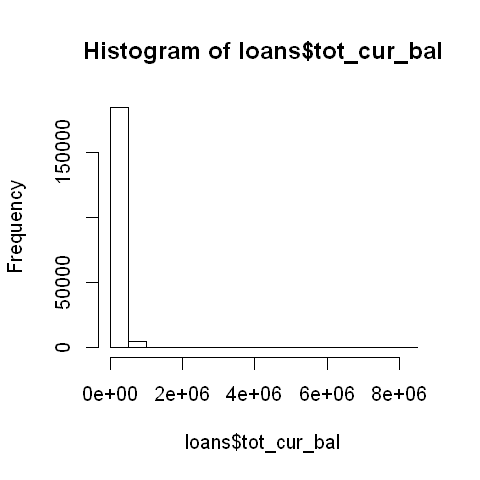

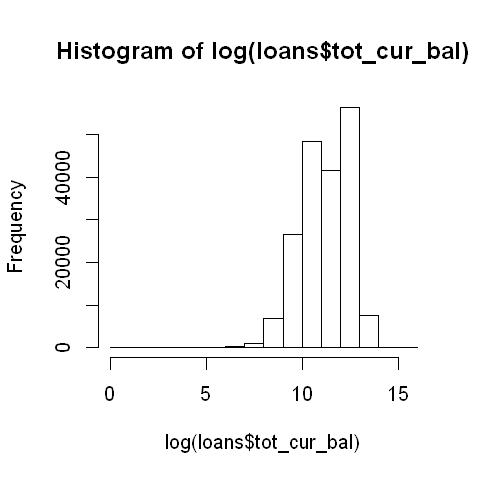

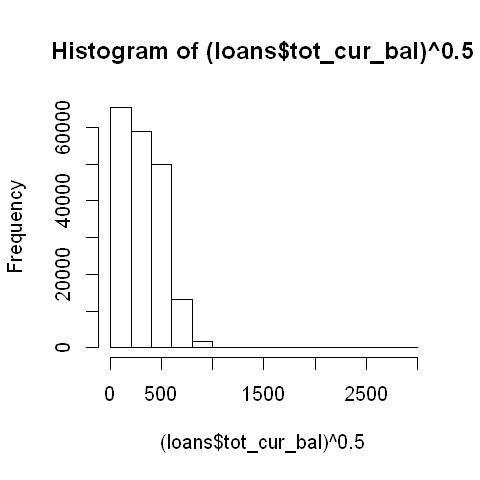

In [80]:
hist(loans$tot_cur_bal)
hist(log(loans$tot_cur_bal))
hist((loans$tot_cur_bal)^0.5)

Warning message in bplt(at[i], wid = width[i], stats = z$stats[, i], out = z$out[z$group == :
"Outlier (-Inf) in boxplot 1 is not drawn"

[1] 671

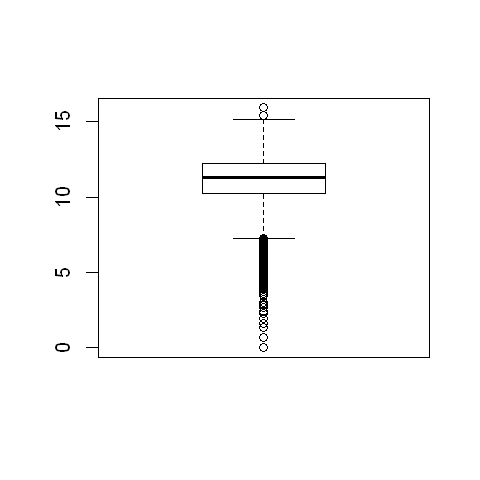

In [81]:
plt17.1<- boxplot(log(loans$tot_cur_bal))
length(plt17.1$out)

[1] 862

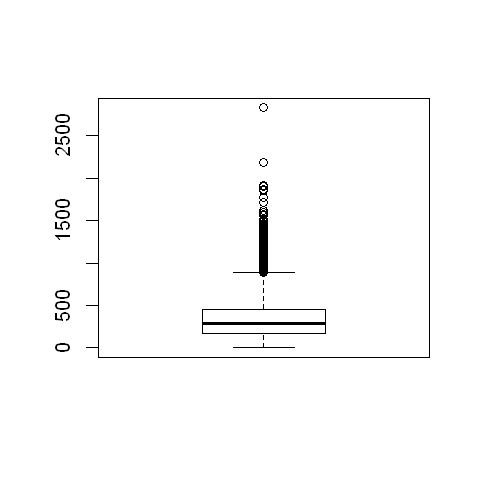

In [82]:
plt17.2<- boxplot(loans$tot_cur_bal^0.5)
length(plt17.2$out)

The outliers number did dramatically decreesed, as consequence of both the root transformation and the log transformation. 

<b>(18) open_acc_6m

A count variable

[1] 6 6

[1] 2

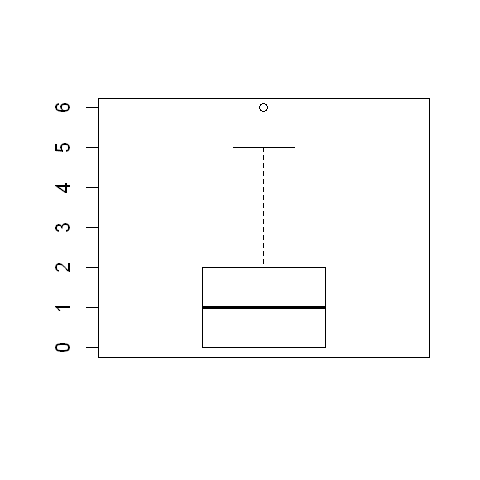

In [83]:
options(repr.plot.width = 4, repr.plot.height = 4)
plt28<- boxplot(loans$open_acc_6m)

head((plt28$out),70)
length(plt28$out)

In [84]:
sum(loans$open_acc_6m!=6,na.rm=TRUE)

[1] 142

In [85]:
sum(loans$open_acc_6m==0,na.rm=TRUE)

[1] 46

this variable have just 6 different values, when just two sample from all of our data set got the value 6.
Also we can see that almost for all loans this varaieble contains NA!

<b>(19) open_il_6m

[1] 11 10  9 18  9  9 10 16 11 11 12 13

[1] 12

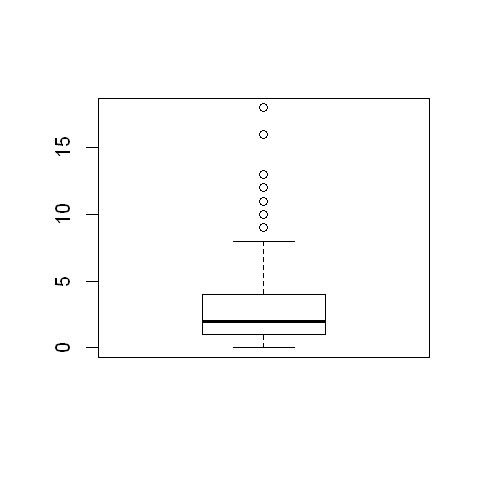

In [86]:
options(repr.plot.width = 4, repr.plot.height = 4)
plt19<- boxplot(loans$open_il_6m)

head((plt19$out),70)
length(plt19$out)

In [87]:
sum(loans$open_il_6m<50,na.rm=TRUE)

[1] 144

we can see that almost for all loans this variable contains NA

<b>(20) open_il_12m

[1] 3 3 3 4 5 3 4 3 6 3 3 4 3 3 3 5

[1] 16

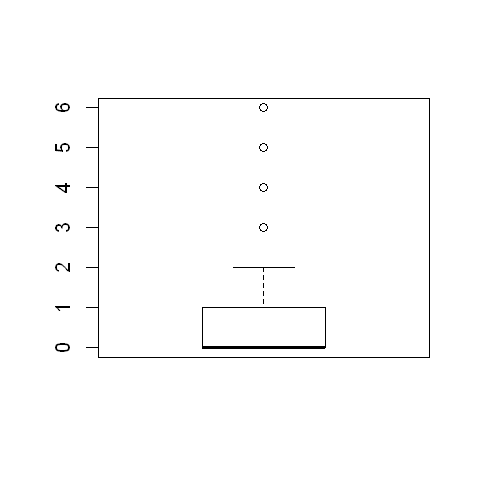

In [88]:
options(repr.plot.width = 4, repr.plot.height = 4)
plt20<- boxplot(loans$open_il_12m)


head((plt20$out),70)
length(plt20$out)

In [89]:
sum(loans$open_il_12m<1000,na.rm=TRUE)

[1] 144


we can see that almost for all loans this variable contains NA


<b>(21) open_il_24m

[1]  7  7  7 11  7 14

[1] 6

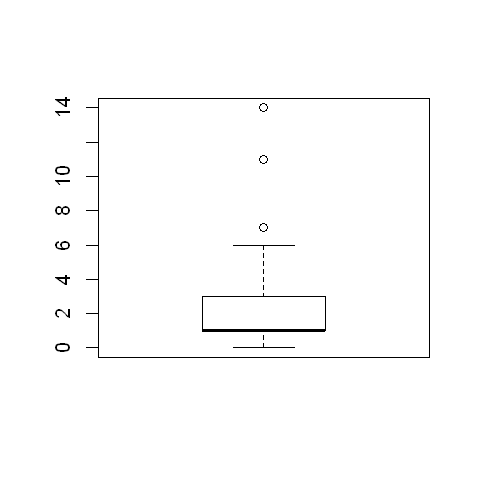

In [90]:
options(repr.plot.width = 4, repr.plot.height = 4)
plt31<- boxplot(loans$open_il_24m)

head((plt31$out),70)
length(plt31$out)

In [91]:
sum(loans$open_il_24m<1000,na.rm=TRUE)

[1] 144

we can see that almost for all loans this variable contains NA

<b>(22) mths_since_rcnt_il

[1]  90 110 103 141  72  63  49  79  81  88 112  54 137  51 121

[1] 15

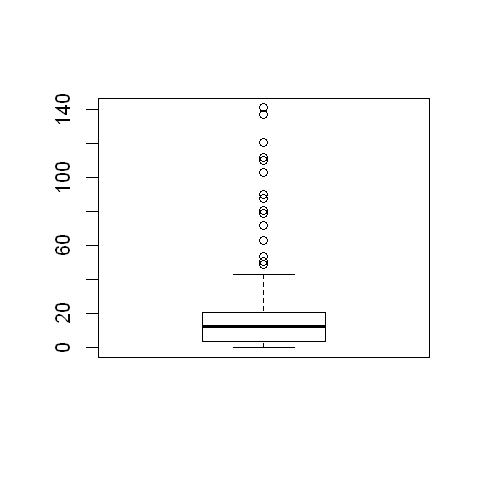

In [92]:
options(repr.plot.width = 4, repr.plot.height = 4)
plt25<- boxplot(loans$mths_since_rcnt_il)

head((plt25$out),70)
length(plt25$out)

In [93]:
sum(loans$mths_since_rcnt_il<1000,na.rm=TRUE)

[1] 140

we can see that almost for all loans this variable contains NA

 <b>(23) total_bal_il

[1] 118231 188977 114725 128545 122441 152925 114239 249212

[1] 8

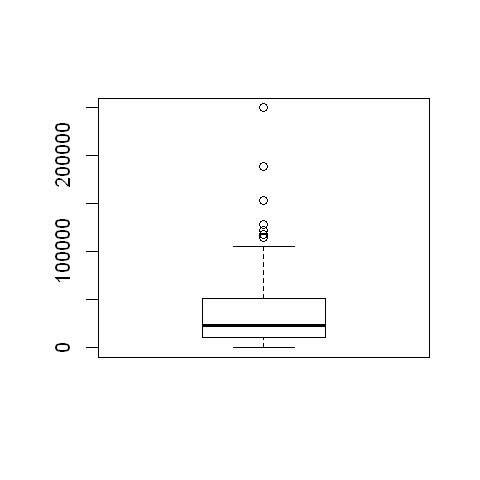

In [94]:
options(repr.plot.width = 4, repr.plot.height = 4)
plt25<- boxplot(loans$total_bal_il)

head((plt25$out),70)
length(plt25$out)

In [95]:
sum(loans$total_bal_il<1000,na.rm=TRUE)

[1] 17

we can see that almost for all loans this variable contains NA

<b>(24) il_util

[1]  25.6  23.4 129.2  23.3  25.0   0.0  18.5   7.8

[1] 8

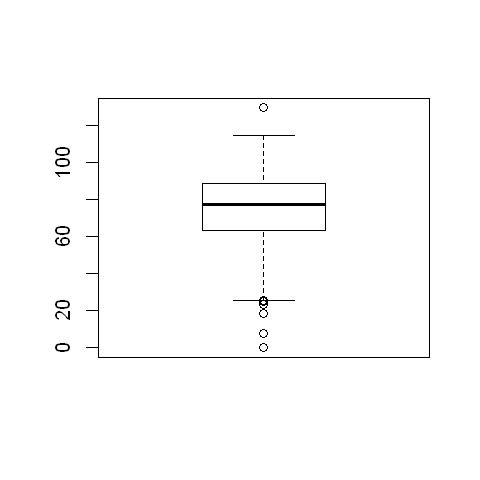

In [96]:
options(repr.plot.width = 4, repr.plot.height = 4)
plt25<- boxplot(loans$il_util)

head((plt25$out),70)
length(plt25$out)

In [97]:
sum(loans$il_util<1000,na.rm=TRUE)

[1] 126

we can see that almost for all loans this variable contains NA

<b>(25) open_rv_12m

[1] 8 7 7

[1] 3

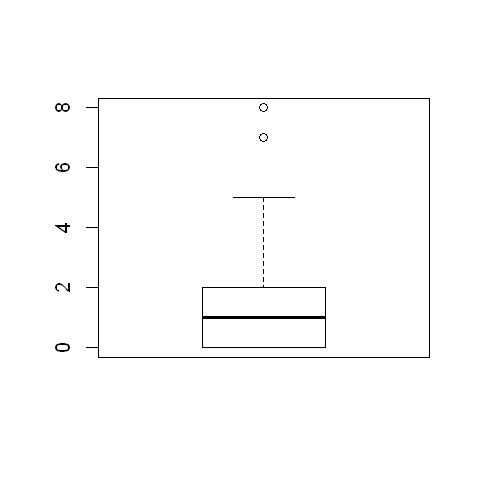

In [98]:
options(repr.plot.width = 4, repr.plot.height = 4)
plt25<- boxplot(loans$open_rv_12m)

head((plt25$out),70)
length(plt25$out)

In [99]:
sum(loans$open_rv_12m<1000,na.rm=TRUE)

[1] 144

we can see that almost for all loans this variable contains NA

 <b>(26) open_rv_24m

[1] 10 11 12 21

[1] 4

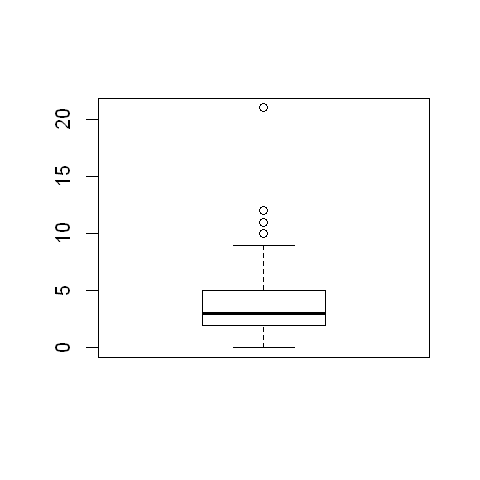

In [100]:
options(repr.plot.width = 4, repr.plot.height = 4)
plt25<- boxplot(loans$open_rv_24m)

head((plt25$out),70)
length(plt25$out)

In [101]:
sum(loans$open_rv_24m<1000,na.rm=TRUE)

[1] 144

we can see that almost for all loans this variable contains NA

<b>(27) max_bal_bc

[1] 22279 18252 20134

[1] 3

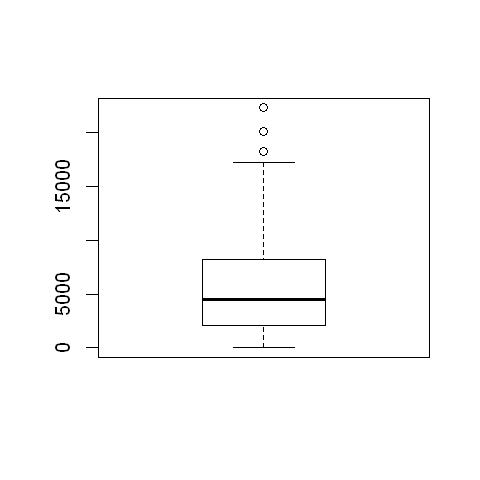

In [102]:
options(repr.plot.width = 4, repr.plot.height = 4)
plt25<- boxplot(loans$max_bal_bc)

head((plt25$out),70)
length(plt25$out)

In [103]:
sum(loans$max_bal_bc<100000,na.rm=TRUE)

[1] 144

we can see that almost for all loans this variable contains NA

<b>(28) all_util

As we have shown in the EDA notebook, this variable is normaly distributed

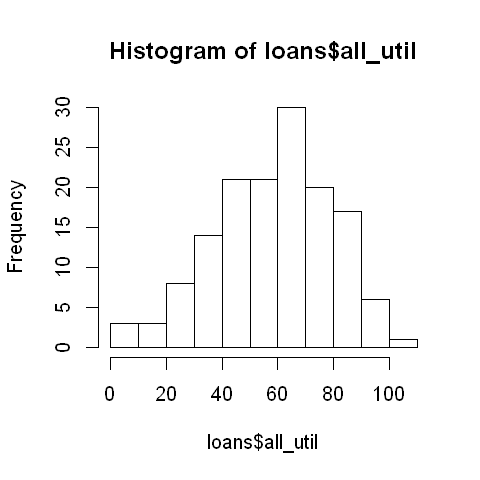

In [104]:
hist(loans$all_util)

In [105]:
sum(loans$all_util<100000,na.rm=TRUE)

[1] 144

For our disappointment, also for this variable, almost for all loans this variable contains NA. 
For educational purpose, we continue with our investigation, even though it is almost sure that this variable 
will be excluded in the missing data stage.
Therefore, first we will use the IQR method and after the z method.


numeric(0)

[1] 0

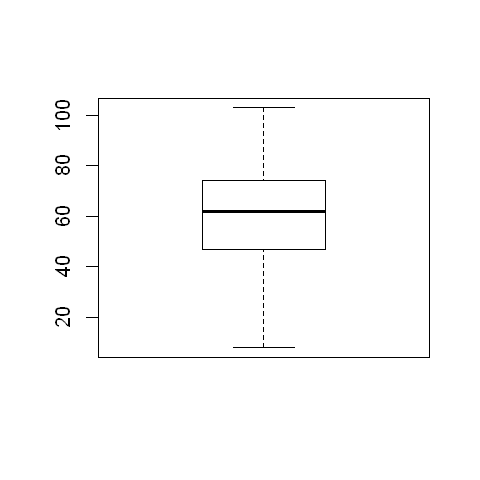

In [106]:
#IQR
options(repr.plot.width = 4, repr.plot.height = 4)
plt25<- boxplot(loans$all_util)

head((plt25$out),70)
length(plt25$out)

In [107]:
#z
z_outlaiers<- function(x, outs_bound=2.7, na_rm=TRUE){
    z_x<-abs(scale(x))
    is_out<-z_x>outs_bound
    outs<-ifelse(sum(is_out,na.rm=TRUE)==0,0, x[is_out])
    
    outs<-ifelse(na_rm , outs[!is.na(outs)]  ,outs)
    outs<-ifelse(sum(is_out,na.rm=TRUE)==0,"There is no outliers!", outs)
    return (outs)
}

plt<-z_outlaiers(loans$all_util,2.7, na_rm=TRUE )
length(plt)
head(plt)

[1] 1

[1] "There is no outliers!"

We set the boundary to Z==2.7, which is the equivalent to IQR==2 in the theoretical normal distribution.
<br>Hence, it is not surprising that there is no outliers also according to this test.

Acording to both methods, thare is no outlaiers

<b>(29) total_rev_hi_lim

[1] 104846  80700 123700  76700  91300  95100  88500  79700  96200  93000
[11]  90600  77100  76500  78000  85781 161500  96300  77600  73500  74200
[21] 178700 122074  89300  84700  74200  73951  81061 106600  73118  87400
[31]  81000  80000  83500 111500 109321  77000 132300 116700  91000  75000
[41] 118400 134800  72181  89900  75100  80500 118300  82400  73500  87259
[51]  83757 105000 544100  75500 162700 223900  84000  73386 140700  85500
[61]  91600  81900 149800 102291  78400  75700 120700  73500 130100 103882

[1] 10740

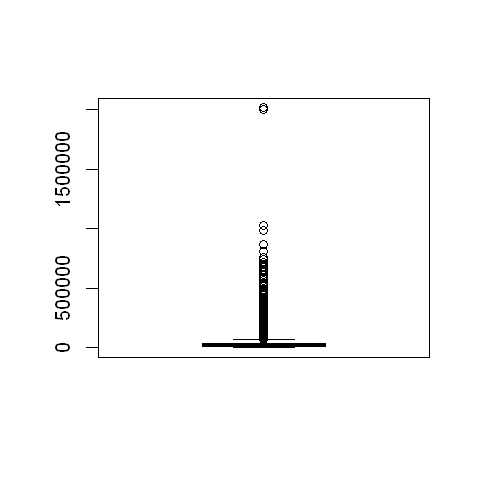

In [108]:
options(repr.plot.width = 4, repr.plot.height = 4)
plt29<- boxplot(loans$total_rev_hi_lim)

head((plt29$out),70)
length(plt29$out)

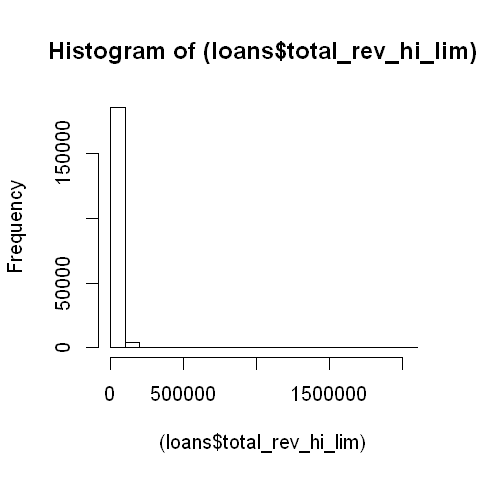

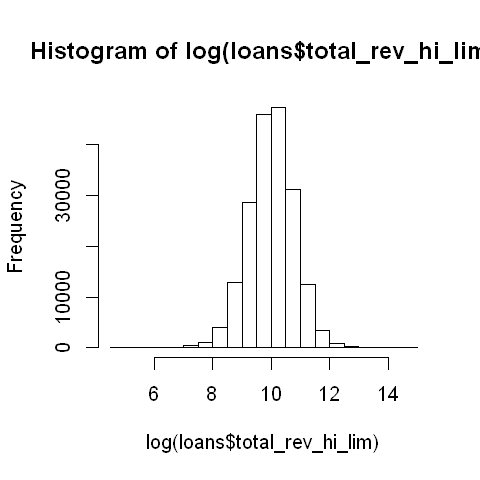

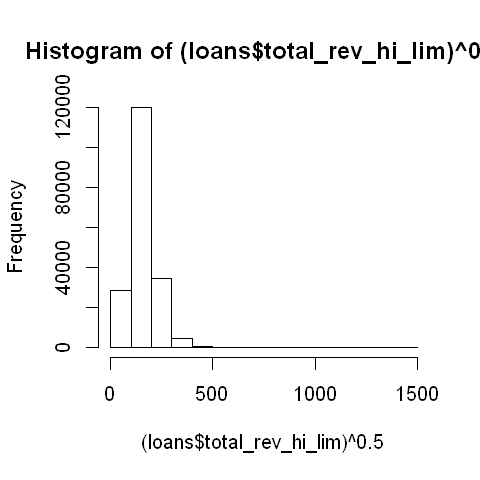

In [109]:
hist((loans$total_rev_hi_lim))
hist(log(loans$total_rev_hi_lim))
hist((loans$total_rev_hi_lim)^0.5)

Warning message in bplt(at[i], wid = width[i], stats = z$stats[, i], out = z$out[z$group == :
"Outlier (-Inf) in boxplot 1 is not drawn"

[1] 2856

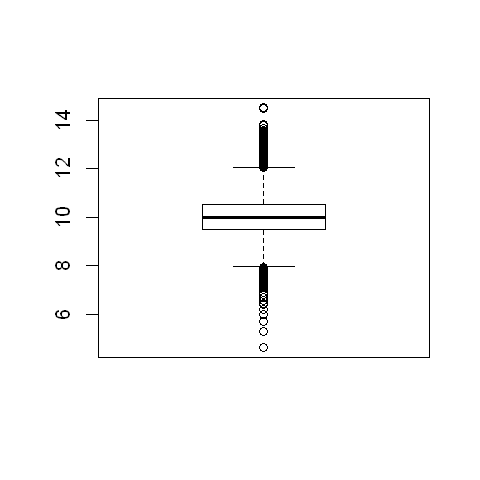

In [110]:
plt29.1<- boxplot(log(loans$total_rev_hi_lim))

length(plt29.1$out)

[1] 5388

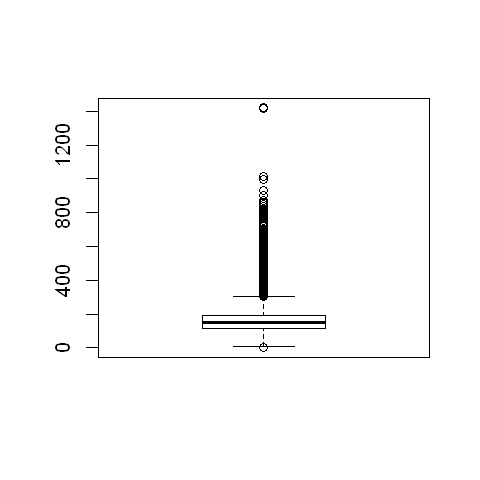

In [111]:
plt29.2<- boxplot(loans$total_rev_hi_lim^0.5)

length(plt29.2$out)

The outliers number did dramatically decreesed, as consequence of both the root transformation and the log transformation.
<br> but the log transformation did a better job.

<b>(30) inq_fi

[1] 5 4 3 3 7 9 4 4 4 3 4 7 5 3 3 5 3 7 6 5 6 7 3

[1] 23

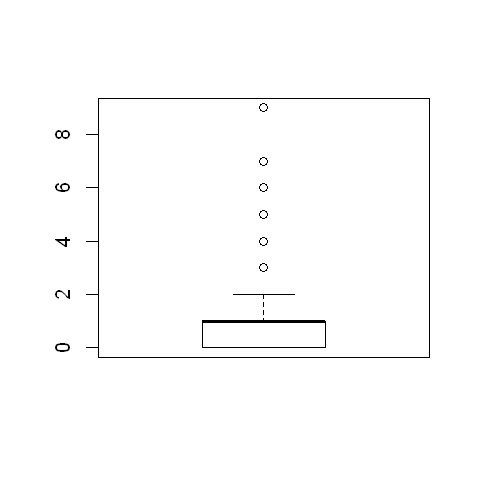

In [112]:
options(repr.plot.width = 4, repr.plot.height = 4)
plt25<- boxplot(loans$inq_fi)

head((plt25$out),70)
length(plt25$out)

In [113]:
sum(loans$inq_fi<100000,na.rm=TRUE)

[1] 144

this variable contains NA almost for all loans and will be probably excluded in the missing data stage .

<b>(31) total_cu_tl

[1] 18  7  8  9 21 10 12  7 12  6 12  7 11 13 17  6  8 15

[1] 18

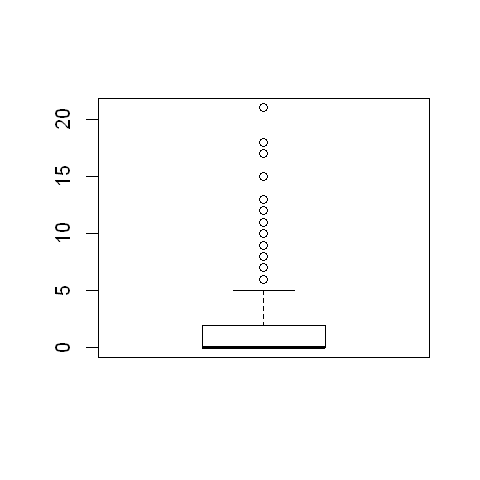

In [114]:
options(repr.plot.width = 4, repr.plot.height = 4)
plt31<- boxplot(loans$total_cu_tl)

head((plt31$out),70)
length(plt31$out)

In [115]:
sum(loans$total_cu_tl<100000,na.rm=TRUE)

[1] 144

this variable contains NA almost for all loans and will be probably excluded in the missing data stage .

<b>(32) inq_last_12m

[1] -4 -4 10 10 -4 -4 -4 -4 -4 -4 -4 15 -4 10 -4 10 -4 16 12 13 12 19 11 -4 -4
[26] 12

[1] 26

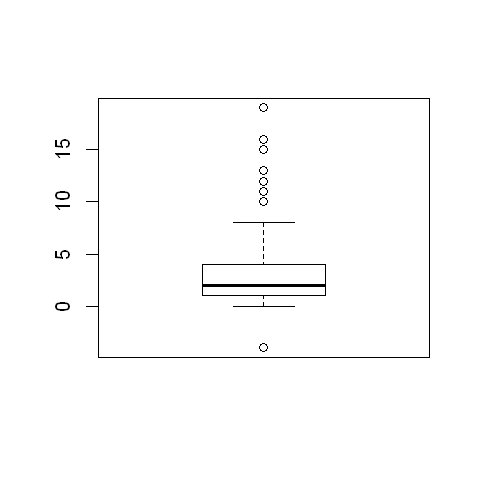

In [116]:
options(repr.plot.width = 4, repr.plot.height = 4)
plt32<- boxplot(loans$inq_last_12m)

head((plt32$out),70)
length(plt32$out)

In [117]:
sum(loans$inq_last_12m<100,na.rm=TRUE)

[1] 144

this variable contains NA almost for all loans and will be probably excluded in the missing data stage .

<b>(33)acc_ratio

[1] 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000
 [8] 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000
[15] 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000
[22] 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000
[29] 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000
[36] 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000
[43] 1.0000000 1.0000000 1.0000000 1.0000000 0.9411765 0.9444444 1.0000000
[50] 1.0000000 1.7500000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000
[57] 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000
[64] 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000

[1] 3364

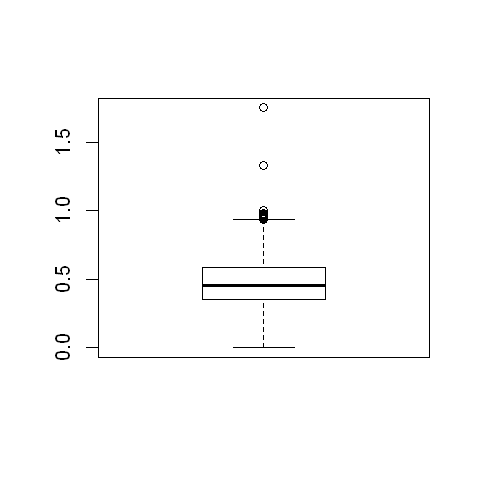

In [118]:
options(repr.plot.width = 4, repr.plot.height = 4)
plt33<- boxplot(loans$acc_ratio)

head((plt33$out),70)
length(plt33$out)

In [119]:
sum(loans$acc_ratio<1,na.rm=TRUE)
sum(loans$acc_ratio==1,na.rm=TRUE)
sum(loans$acc_ratio>1,na.rm=TRUE)

[1] 252590

[1] 3099

[1] 2

We found two people with more open accounts than total accounts, wich by definition is not possible.


In [120]:

Lmax<-loans[loans$acc_ratio>1,]
Lmax[!is.na(Lmax$total_acc),]

,verification_status,issue_d,pymnt_plan,purpose,initial_list_status,emp_length,loan_amnt,funded_amnt,funded_amnt_inv,term,...,annual_inc_rt,inc_grp,revol_bal_rt,credit_hist_log,credit_hist_rt,credit_hist_grp,max_L,max_fund_L,MAX_fund_L_inv,is_acc_now_delinq_not_zero
300,Not Verified,2007-09-01,0,debt_consolidation,1,10+ years,2000,2000,1575,0,...,343.5113,high_inc,68.62215,2.944439,4.358899,17-21_yrs,0,0,0,0
448,Not Verified,2007-09-01,0,car,1,< 1 year,4000,4000,2675,0,...,223.6068,low_inc,80.62258,1.098612,1.732051,<4_yrs,0,0,0,0


This two loans have the same issue date, what makes it more suspicious.
For this reason we decided to replace this values with NA.


In [121]:
loans$total_acc [(loans$acc_ratio>1)]<-NA
loans$open_acc[(loans$acc_ratio>1)]<-NA

In [122]:
loans$acc_ratio[(loans$acc_ratio>1)]<-NA

<b>(34)credit_hist [credit_hist_log, credit_hist_rt]

[1] 38 36 38 40 36 47 47 39 43 36 34 34 39 35 42 35 36 41 35 34 39 46 37 34 38
[26] 38 35 40 37 35 39 40 34 34 35 45 38 35 35 35 37 36 34 36 42 41 38 34 41 37
[51] 41 46 36 35 49 40 35 45 34 37 34 34 35 44 40 34 35 42 37 36

[1] 7903

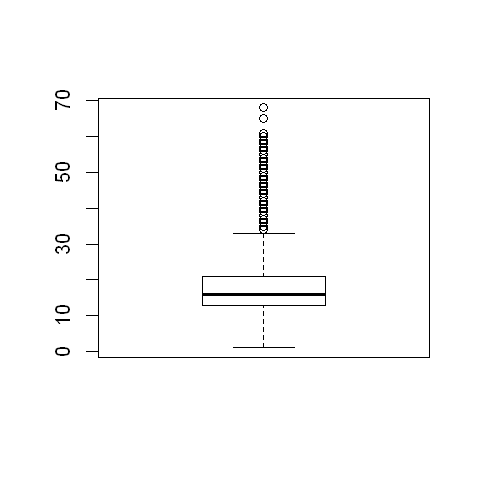

In [123]:
options(repr.plot.width = 4, repr.plot.height = 4)
plt34<- boxplot(loans$credit_hist)

head((plt34$out),70)
length(plt34$out)

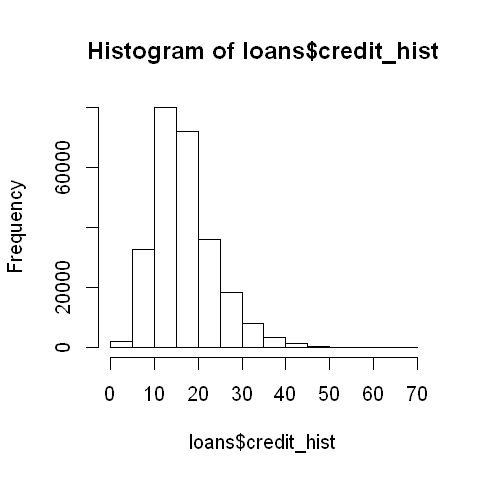

In [124]:
hist(loans$credit_hist)

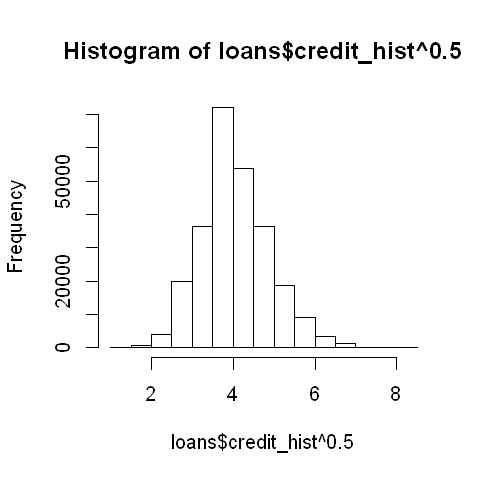

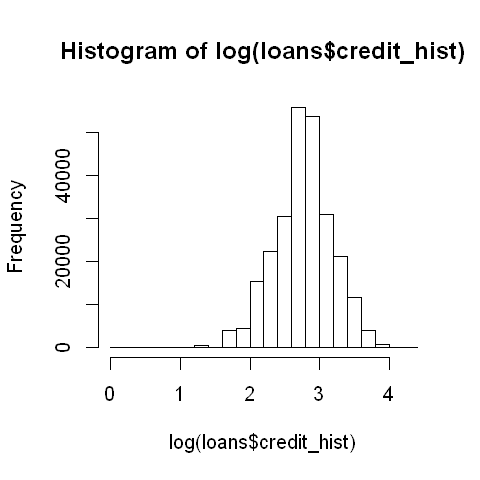

In [125]:
hist(loans$credit_hist^0.5)
hist(log(loans$credit_hist))

[1] 5636

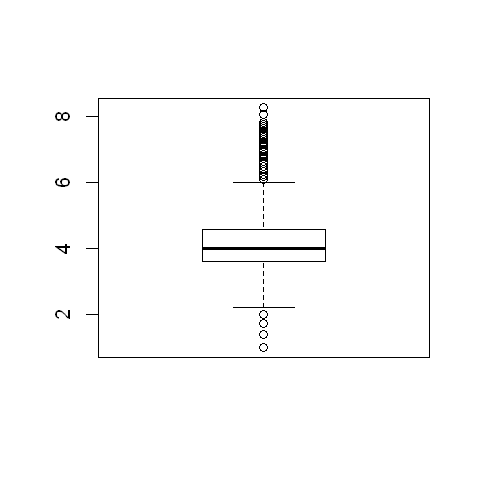

In [126]:

plt34<- boxplot(loans$credit_hist^0.5)

length(plt34$out)

[1] 6060

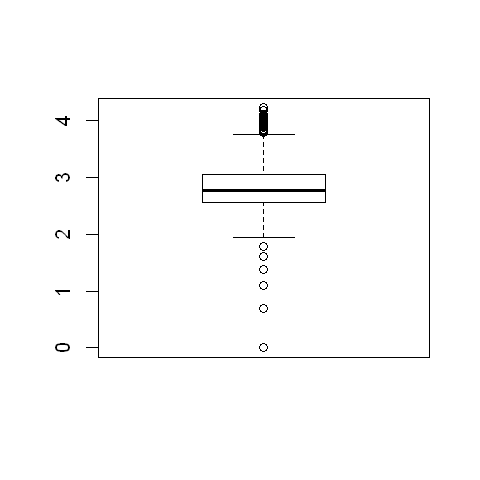

In [127]:
plt34<- boxplot(log(loans$credit_hist))

length(plt34$out)

The outliers number did decreesed a bit, as consequence of both the root transformation and the log transformation.

<b>(35)poverty_rate_p

[1] 0.058 0.058 0.058 0.058 0.058 0.058 0.231 0.231 0.231 0.231 0.231 0.231
[13] 0.231 0.231 0.231 0.231 0.231 0.231 0.231 0.231 0.231 0.231 0.231 0.231
[25] 0.231 0.231 0.231 0.231 0.231 0.231 0.231 0.231 0.231 0.231 0.231 0.231
[37] 0.231 0.231 0.231 0.231 0.231 0.231 0.231 0.231 0.231 0.231 0.231 0.231
[49] 0.231 0.231 0.231 0.231 0.231 0.231 0.231 0.231 0.231 0.231 0.231 0.231
[61] 0.231 0.231 0.231 0.231 0.231 0.231 0.231 0.231 0.231 0.231

[1] 804

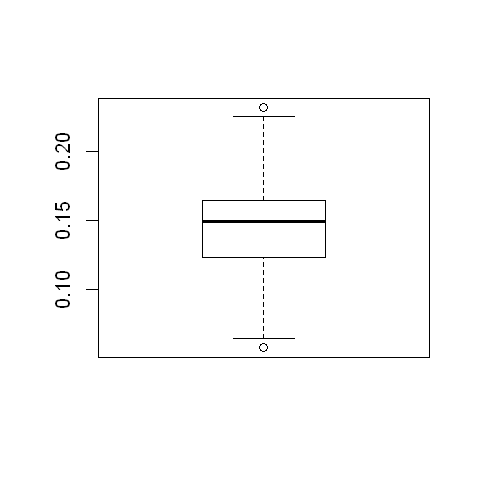

In [128]:
options(repr.plot.width = 4, repr.plot.height = 4)
plt35<- boxplot(loans$poverty_rate_p)

head((plt35$out),70)
length(plt35$out)

This variable is taken from official data of each country each year. When for each year and country varies it is the same.
In addition, it can be seen that most of the outliers are located near the outliers boarder line.

<b> (36) collections_12_mths_ex_med

[1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[39] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1

[1] 1574

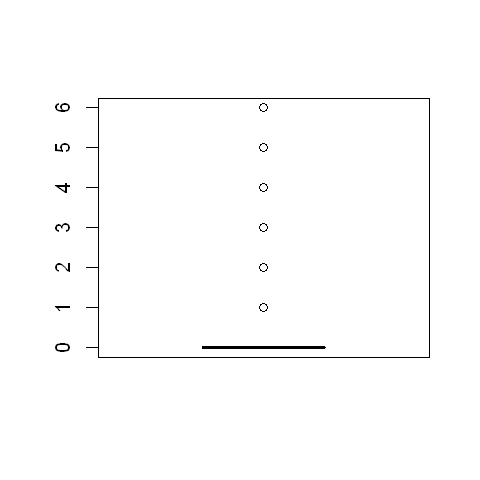

In [129]:
options(repr.plot.width = 4, repr.plot.height = 4)
plt36<- boxplot(loans$collections_12_mths_ex_med)

head((plt36$out),70)
length(plt36$out)

In [130]:
sum(is.na(loans$collections_12_mths_ex_med))



[1] 145

Most of the values of this variable is 1 or 0, as we can see from the new variable we created at the feature engineering notebook 

In [131]:
summary(loans$cat_collections_12_mths_ex_med)

one or more        zero        NA's 
       1574      254001         145

<b>(37) pub_rec

[1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1
[39] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

[1] 31183

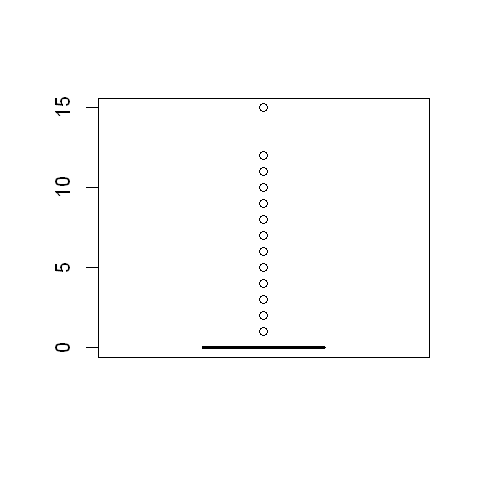

In [132]:
options(repr.plot.width = 4, repr.plot.height = 4)
plt37<- boxplot(loans$pub_rec)

head((plt37$out),70)
length(plt37$out)

In [133]:
sum(is.na(loans$pub_rec))

[1] 29

Most of the values of this variable is 1 or 0, as we can see from the new variable we created at the feature engineering notebook 

In [134]:
summary(loans$cat_pub_rec)

one or more        zero        NA's 
      31183      224508          29

## Multivariate Outlier Analysis

For multivariate outlier detection we can use DBSCAN. This algorithm search for aggregation of points that are combined and leave out of them the outlier points.

<img src="https://en.proft.me/media/science/r_dbc_points.png"> </img>



In [135]:
##sample 
k<-loans


In [136]:
k_num<-NULL
k_cat<-NULL
k_num<-k[num_vars]
k_cat<-k[,cat_vars]


### preparing the data

### numerics variables
#### deminishing missingness

In [137]:
sum(is.na(k_num),na.rm=TRUE)

[1] 4493747

In [138]:
ind <- is.na(k_num)
k_num[ind] <- rep(9999999, sum(ind))


In [139]:
head(k_num)

loan_amnt,funded_amnt,funded_amnt_inv,collections_12_mths_ex_med,mths_since_last_major_derog,annual_inc,dti,delinq_2yrs,acc_now_delinq,inq_last_6mths,...,credit_hist,poverty_rate_p,mths_since_last_delinq_rt,open_acc_rt,total_acc_rt,annual_inc_log,annual_inc_rt,revol_bal_rt,credit_hist_log,credit_hist_rt
10000,10000,2175.000,0,9999999,36400,18.92,0,0,1,...,11,0.145,6.403124,3.000000,4.472136,10.502324,190.7878,95.73923,2.397895,3.316625
5400,5400,375.000,0,9999999,42000,16.09,0,0,0,...,8,0.145,0.000000,3.316625,3.464102,10.645425,204.9390,195.07434,2.079442,2.828427
1500,1500,583.050,0,9999999,15600,14.23,0,0,4,...,7,0.145,0.000000,2.000000,2.000000,9.655026,124.9000,79.44810,1.945910,2.645751
4800,4800,1550.000,0,9999999,60000,12.94,0,0,3,...,11,0.145,7.745967,3.464102,4.898979,11.002100,244.9490,53.12250,2.397895,3.316625
4800,4800,1625.000,0,9999999,25000,18.19,1,0,0,...,10,0.145,3.000000,2.236068,4.123106,10.126631,158.1139,20.22375,2.302585,3.162278
4200,4200,1125.002,0,9999999,24000,12.55,0,0,9,...,15,0.145,7.000000,1.414214,1.732051,10.085809,154.9193,0.00000,2.708050,3.872983


#### scaling

In [140]:
k.norm<-scale(k_num)
k.norm<-k.norm[, colSums(is.nan(k.norm)) != nrow(k.norm)]
head(k.norm)

loan_amnt,funded_amnt,funded_amnt_inv,collections_12_mths_ex_med,mths_since_last_major_derog,annual_inc,dti,delinq_2yrs,acc_now_delinq,inq_last_6mths,...,credit_hist,poverty_rate_p,mths_since_last_delinq_rt,open_acc_rt,total_acc_rt,annual_inc_log,annual_inc_rt,revol_bal_rt,credit_hist_log,credit_hist_rt
-0.4324024,-0.4283814,-1.373075,-0.02381905,0.4779003,-0.5123873,0.30838817,-0.01065212,-0.0106498,-0.01064872,...,-0.01416921,-0.005395534,-1.117601,-0.01065190,-0.01065342,-0.003968791,-0.005687158,-0.2824776,-0.01412630,-0.01412911
-0.9984111,-0.9959620,-1.594203,-0.02381905,0.4779003,-0.4333013,-0.05501773,-0.01065212,-0.0106498,-0.01065811,...,-0.01419046,-0.005395534,-1.117602,-0.01064893,-0.01066289,-0.003965173,-0.005329344,1.5443824,-0.01412855,-0.01413256
-1.4782881,-1.4771717,-1.568644,-0.02381905,0.4779003,-0.8061353,-0.29386401,-0.01065212,-0.0106498,-0.01062055,...,-0.01419754,-0.005395534,-1.117602,-0.01066129,-0.01067664,-0.003990214,-0.007353143,-0.5820858,-0.01412950,-0.01413386
-1.0722383,-1.0699943,-1.449855,-0.02381905,0.4779003,-0.1790963,-0.45951546,-0.01065212,-0.0106498,-0.01062994,...,-0.01416921,-0.005395534,-1.117601,-0.01064754,-0.01064942,-0.003956154,-0.004317686,-1.0662366,-0.01412630,-0.01412911
-1.0722383,-1.0699943,-1.440642,-0.02381905,0.4779003,-0.6733838,0.21464742,-0.01064273,-0.0106498,-0.01065811,...,-0.01417630,-0.005395534,-1.117602,-0.01065908,-0.01065670,-0.003978290,-0.006513324,-1.6712736,-0.01412697,-0.01413020
-1.1460656,-1.1440266,-1.502066,-0.02381905,0.4779003,-0.6875063,-0.50959613,-0.01065212,-0.0106498,-0.01057360,...,-0.01414089,-0.005395534,-1.117601,-0.01066680,-0.01067916,-0.003979322,-0.006594099,-2.0432060,-0.01412410,-0.01412517


### categorical variables
#### get Dummys

In [141]:
k_dummy<-createDummyFeatures(k[,cat_vars], cols = cat_vars)
k_dummy[is.na(k_dummy)]<-0.4116079

In [142]:
sum(is.na(k_dummy))

[1] 0

In [143]:
k_bin_vars<-k[,bin_vars]


In [144]:
k_bin_vars[is.na(k_bin_vars)]<- -0.4116079

In [145]:
k_data<-cbind(k.norm,k_dummy,k_bin_vars)

In [147]:
dim(k_data)
head(k_data)

[1] 255720    165

loan_amnt,funded_amnt,funded_amnt_inv,collections_12_mths_ex_med,mths_since_last_major_derog,annual_inc,dti,delinq_2yrs,acc_now_delinq,inq_last_6mths,...,inc_grp.verylow_inc,credit_hist_grp..4_yrs,credit_hist_grp..21_yrs,credit_hist_grp.13.17_yrs,credit_hist_grp.17.21_yrs,credit_hist_grp.4.13_yrs,max_L,max_fund_L,MAX_fund_L_inv,is_acc_now_delinq_not_zero
-0.4324024,-0.4283814,-1.373075,-0.02381905,0.4779003,-0.5123873,0.30838817,-0.01065212,-0.0106498,-0.01064872,...,1,0,0,0,0,1,0,0,0,0
-0.9984111,-0.9959620,-1.594203,-0.02381905,0.4779003,-0.4333013,-0.05501773,-0.01065212,-0.0106498,-0.01065811,...,1,0,0,0,0,1,0,0,0,0
-1.4782881,-1.4771717,-1.568644,-0.02381905,0.4779003,-0.8061353,-0.29386401,-0.01065212,-0.0106498,-0.01062055,...,1,0,0,0,0,1,0,0,0,0
-1.0722383,-1.0699943,-1.449855,-0.02381905,0.4779003,-0.1790963,-0.45951546,-0.01065212,-0.0106498,-0.01062994,...,0,0,0,0,0,1,0,0,0,0
-1.0722383,-1.0699943,-1.440642,-0.02381905,0.4779003,-0.6733838,0.21464742,-0.01064273,-0.0106498,-0.01065811,...,1,0,0,0,0,1,0,0,0,0
-1.1460656,-1.1440266,-1.502066,-0.02381905,0.4779003,-0.6875063,-0.50959613,-0.01065212,-0.0106498,-0.01057360,...,1,0,0,1,0,0,0,0,0,0


<b>PCA visualisation

In [ ]:
#sample data 
set.seed(123)
k_data_semp<- k_data[sample(nrow(k_data), 10000), ]

Warning message in `[.data.table`(embedding, , `:=`(loans, rownames(k))):
"Supplied 255720 items to be assigned to 10000 items of column 'loans' (245720 unused)"

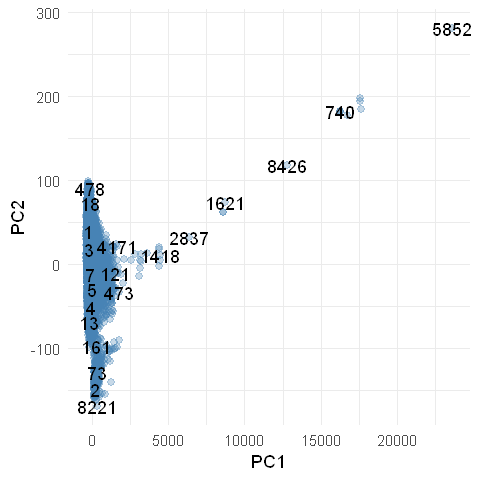

In [149]:
#distance_matrix <- as.matrix(dist(scale(k_data_semp)))
#pca <-prcomp(distance_matrix)
#saveRDS(object =pca ,file = "PCA.rds" )
pca <- readRDS(paste0(getwd(),"/Models/PCA.rds"))
embedding <- data.table(pca$x[, 1:2])
embedding[, loans := rownames(k)]
ggplot(embedding, aes(x = PC1, y = PC2)) +
    geom_point(size = 2, colour = "steelblue", alpha = 0.3) +
    geom_text(aes(label = loans), check_overlap = TRUE) +
    theme_minimal()

#:3

It is nice to have a look on some of the far loans.

In [150]:
k_data[c(5852,740,8426,1621,2821),]

,loan_amnt,funded_amnt,funded_amnt_inv,collections_12_mths_ex_med,mths_since_last_major_derog,annual_inc,dti,delinq_2yrs,acc_now_delinq,inq_last_6mths,...,inc_grp.verylow_inc,credit_hist_grp..4_yrs,credit_hist_grp..21_yrs,credit_hist_grp.13.17_yrs,credit_hist_grp.17.21_yrs,credit_hist_grp.4.13_yrs,max_L,max_fund_L,MAX_fund_L_inv,is_acc_now_delinq_not_zero
5852,0.3981539,0.4044815,0.3702558,-0.02381905,0.4779003,-0.34856632,0.8734009,-0.01064273,-0.0106498,-0.01064872,...,0,0,0,1,0,0,0,0,0,0
740,-0.4939251,-0.4900749,-1.4959235,-0.02381905,0.4779003,0.03274117,-0.6701111,-0.01064273,-0.0106498,-0.01065811,...,0,0,0,1,0,0,0,0,0,0
8426,-1.2198928,-1.2180588,-1.1980154,-0.02381905,0.4779003,8.50691878,-1.9221279,-0.01065212,-0.0106498,-0.01062055,...,0,0,0,1,0,0,0,0,0,0
1621,-1.5398108,-1.5388653,-1.6402708,-0.02381905,0.4779003,-0.60277131,0.9401751,-0.01065212,-0.0106498,-0.01064872,...,1,0,0,0,0,1,0,0,0,0
2821,-0.6723409,-0.6689862,-0.9338906,-0.02381905,0.4779003,-0.17909633,-1.6742928,-0.01065212,-0.0106498,-0.01058299,...,0,0,0,0,0,1,0,0,0,0


### finding outliers with dbscan model

To determine eps value for the dbscan execution we will check the distances of our data.
We will use knndist algorithm on the sample to check the mean distances in our data

In [ ]:
if(!require(knndist)){install.packages("knndist"); require(knndist)}
knnD<- kNNdist(k_data_semp, k=9, search="kd")
apply(knnD,2,min)
apply(knnD,2,max)
apply(knnD,2,mean)


We see that the mean of distances for the knn are around 3.3 so we will determine the eps for DBSCAN as 4

In [ ]:
## dbscan clustering
#mod <-dbscan(k_data, eps = 4 ,minPts =1)
#saveRDS(mod, "db_model.rds")

In [151]:
mod <- readRDS(paste0(getwd(),"/Models/db_model.rds"))
table(mod$cluster)


     1      2      3      4      5      6      7      8      9     10     11 
254794     95      1      1      6     25      1      1      1      3      1 
    12     13     14     15     16     17     18     19     20     21     22 
     1      1      1      2     10      1      1      2      2      2      1 
    23     24     25     26     27     28     29     30     31     32     33 
     4      1      1     75      1      1      1      1      2      1      1 
    34     35     36     37     38     39     40     41     42     43     44 
     1      1      1      2      1      1      1      1      1      1      2 
    45     46     47     48     49     50     51     52     53     54     55 
     1      1      1      7      1      1      1      1      1      2      1 
    56     57     58     59     60     61     62     63     64     65     66 
     2      1      1      1      1      1      2      1      1      1      1 
    67     68     69     70     71     72     73     74     75 

In [158]:
head(k_data)

loan_amnt,funded_amnt,funded_amnt_inv,collections_12_mths_ex_med,mths_since_last_major_derog,annual_inc,dti,delinq_2yrs,acc_now_delinq,inq_last_6mths,...,credit_hist_grp..4_yrs,credit_hist_grp..21_yrs,credit_hist_grp.13.17_yrs,credit_hist_grp.17.21_yrs,credit_hist_grp.4.13_yrs,max_L,max_fund_L,MAX_fund_L_inv,is_acc_now_delinq_not_zero,is_out
-0.4324024,-0.4283814,-1.373075,-0.02381905,0.4779003,-0.5123873,0.30838817,-0.01065212,-0.0106498,-0.01064872,...,0,0,0,0,1,0,0,0,0,FALSE
-0.9984111,-0.9959620,-1.594203,-0.02381905,0.4779003,-0.4333013,-0.05501773,-0.01065212,-0.0106498,-0.01065811,...,0,0,0,0,1,0,0,0,0,FALSE
-1.4782881,-1.4771717,-1.568644,-0.02381905,0.4779003,-0.8061353,-0.29386401,-0.01065212,-0.0106498,-0.01062055,...,0,0,0,0,1,0,0,0,0,FALSE
-1.0722383,-1.0699943,-1.449855,-0.02381905,0.4779003,-0.1790963,-0.45951546,-0.01065212,-0.0106498,-0.01062994,...,0,0,0,0,1,0,0,0,0,FALSE
-1.0722383,-1.0699943,-1.440642,-0.02381905,0.4779003,-0.6733838,0.21464742,-0.01064273,-0.0106498,-0.01065811,...,0,0,0,0,1,0,0,0,0,FALSE
-1.1460656,-1.1440266,-1.502066,-0.02381905,0.4779003,-0.6875063,-0.50959613,-0.01065212,-0.0106498,-0.01057360,...,0,0,1,0,0,0,0,0,0,FALSE


In [159]:
k_data$cluster<-as.vector(mod$cluster)

In [160]:
##sample with clusters
set.seed(123)
k_data_semp<- k_data[sample(nrow(k_data), 10000), ]

In [161]:

embedding[, DClusters := k_data_semp$cluster]

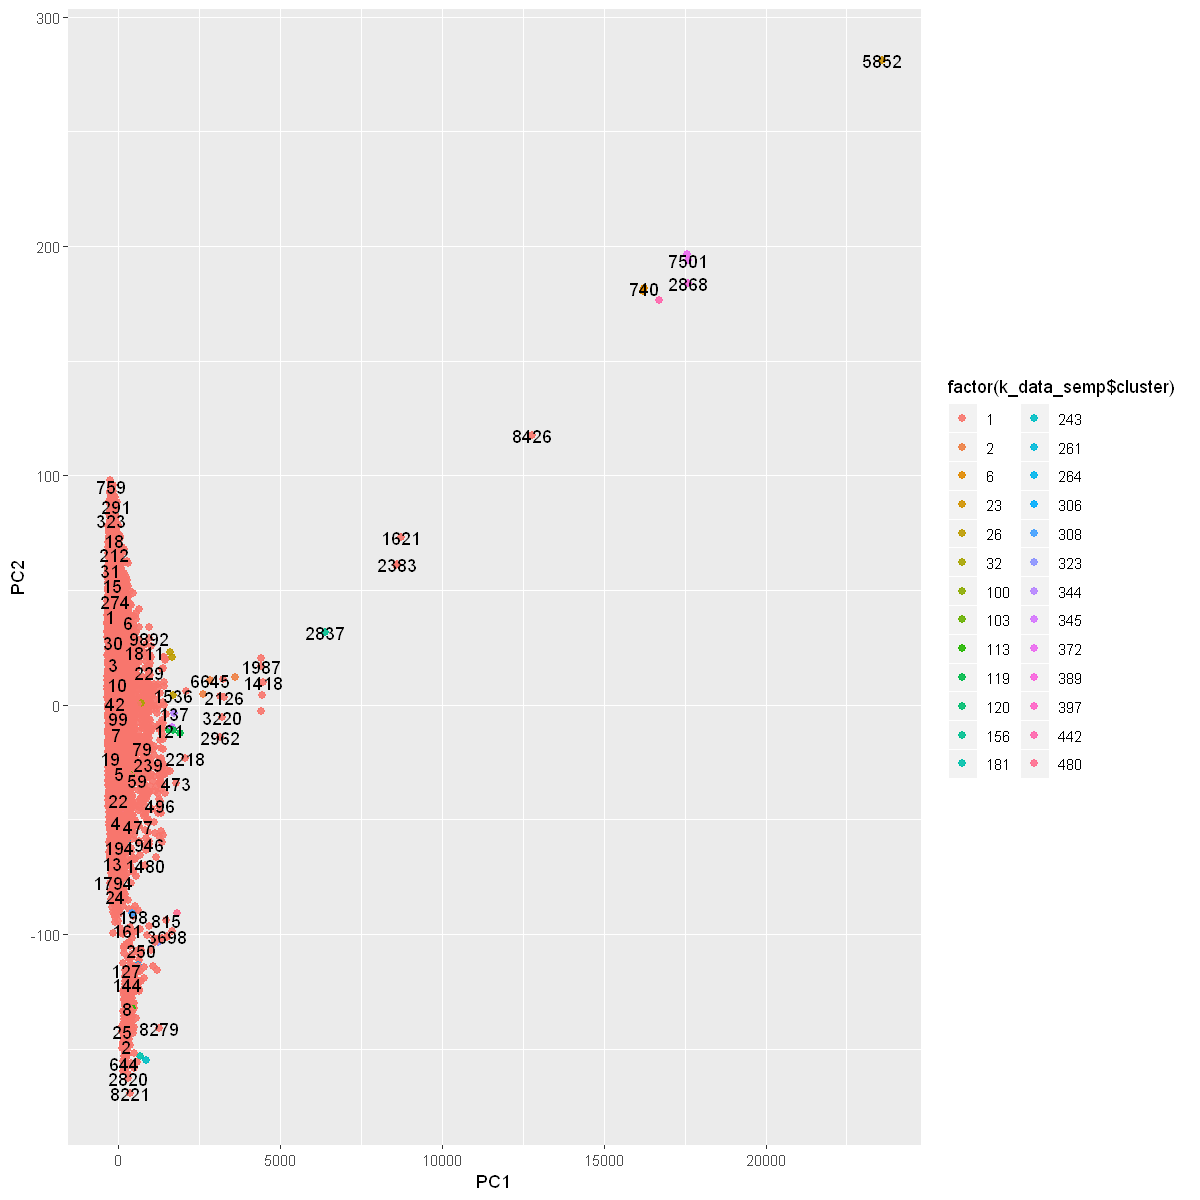

In [162]:
options(repr.plot.width=10, repr.plot.height=10  )
ggplot(embedding, aes(x = PC1, y = PC2)) +
    geom_point(aes(colour = factor(k_data_semp$cluster)), size = 2, alpha = 0.9) +
geom_text(aes(label = loans), check_overlap = TRUE)
    

#### defining the outliers based on dbscan

In [163]:
table(mod$cluster)[table(mod$cluster)>1]


     1      2      5      6     10     15     16     19     20     21     23 
254794     95      6     25      3      2     10      2      2      2      4 
    26     31     37     44     48     54     56     62    112    118    119 
    75      2      2      2      7      2      2      2      2      3     75 
   120    126    129    137    141    143    145    147    156    158    167 
     3      3      3      2      2      3      2      2      4      2      2 
   168    169    172    174    183    190    191    192    204    205    223 
     2      2      8      2      2      2      2      2      2      2      4 
   228    230    250    255    268    296    306    323    324    330    336 
     2      2      2      2      2      2      2      2      2      3      2 
   372    377    378    389    390    391    400    405    420    421    422 
    40      5     24      2      2      2      2      2      4      4      2 
   435    444    471 
     2      5      3 

We see that except of cluster number 1 all other cluster contains a very low percentage of data therefore we will define outliers the loans from every cluster except of cluster #1

In [164]:
k_data$is_out<-!(mod$cluster ==1)


In [165]:
k_data_semp$is_out<-!((k_data_semp$cluster ==1))

In [166]:
head(k_data)

loan_amnt,funded_amnt,funded_amnt_inv,collections_12_mths_ex_med,mths_since_last_major_derog,annual_inc,dti,delinq_2yrs,acc_now_delinq,inq_last_6mths,...,credit_hist_grp..21_yrs,credit_hist_grp.13.17_yrs,credit_hist_grp.17.21_yrs,credit_hist_grp.4.13_yrs,max_L,max_fund_L,MAX_fund_L_inv,is_acc_now_delinq_not_zero,is_out,cluster
-0.4324024,-0.4283814,-1.373075,-0.02381905,0.4779003,-0.5123873,0.30838817,-0.01065212,-0.0106498,-0.01064872,...,0,0,0,1,0,0,0,0,FALSE,1
-0.9984111,-0.9959620,-1.594203,-0.02381905,0.4779003,-0.4333013,-0.05501773,-0.01065212,-0.0106498,-0.01065811,...,0,0,0,1,0,0,0,0,FALSE,1
-1.4782881,-1.4771717,-1.568644,-0.02381905,0.4779003,-0.8061353,-0.29386401,-0.01065212,-0.0106498,-0.01062055,...,0,0,0,1,0,0,0,0,FALSE,1
-1.0722383,-1.0699943,-1.449855,-0.02381905,0.4779003,-0.1790963,-0.45951546,-0.01065212,-0.0106498,-0.01062994,...,0,0,0,1,0,0,0,0,FALSE,1
-1.0722383,-1.0699943,-1.440642,-0.02381905,0.4779003,-0.6733838,0.21464742,-0.01064273,-0.0106498,-0.01065811,...,0,0,0,1,0,0,0,0,FALSE,1
-1.1460656,-1.1440266,-1.502066,-0.02381905,0.4779003,-0.6875063,-0.50959613,-0.01065212,-0.0106498,-0.01057360,...,0,1,0,0,0,0,0,0,FALSE,1


In [167]:
sum(k_data$is_out)

[1] 926

We can see that there is 926 loans that are labeled as outliers, based on DBSCAN clustering and on our labeling.

In [168]:
k_data_outs<-k_data[k_data$is_out,]

In [169]:
k_outs<-k_data[k_data$is_out,]

In [170]:
k_data_in<-k_data[!k_data$is_out,]

In [171]:
k_in<-k_data[!k_data$is_out,]

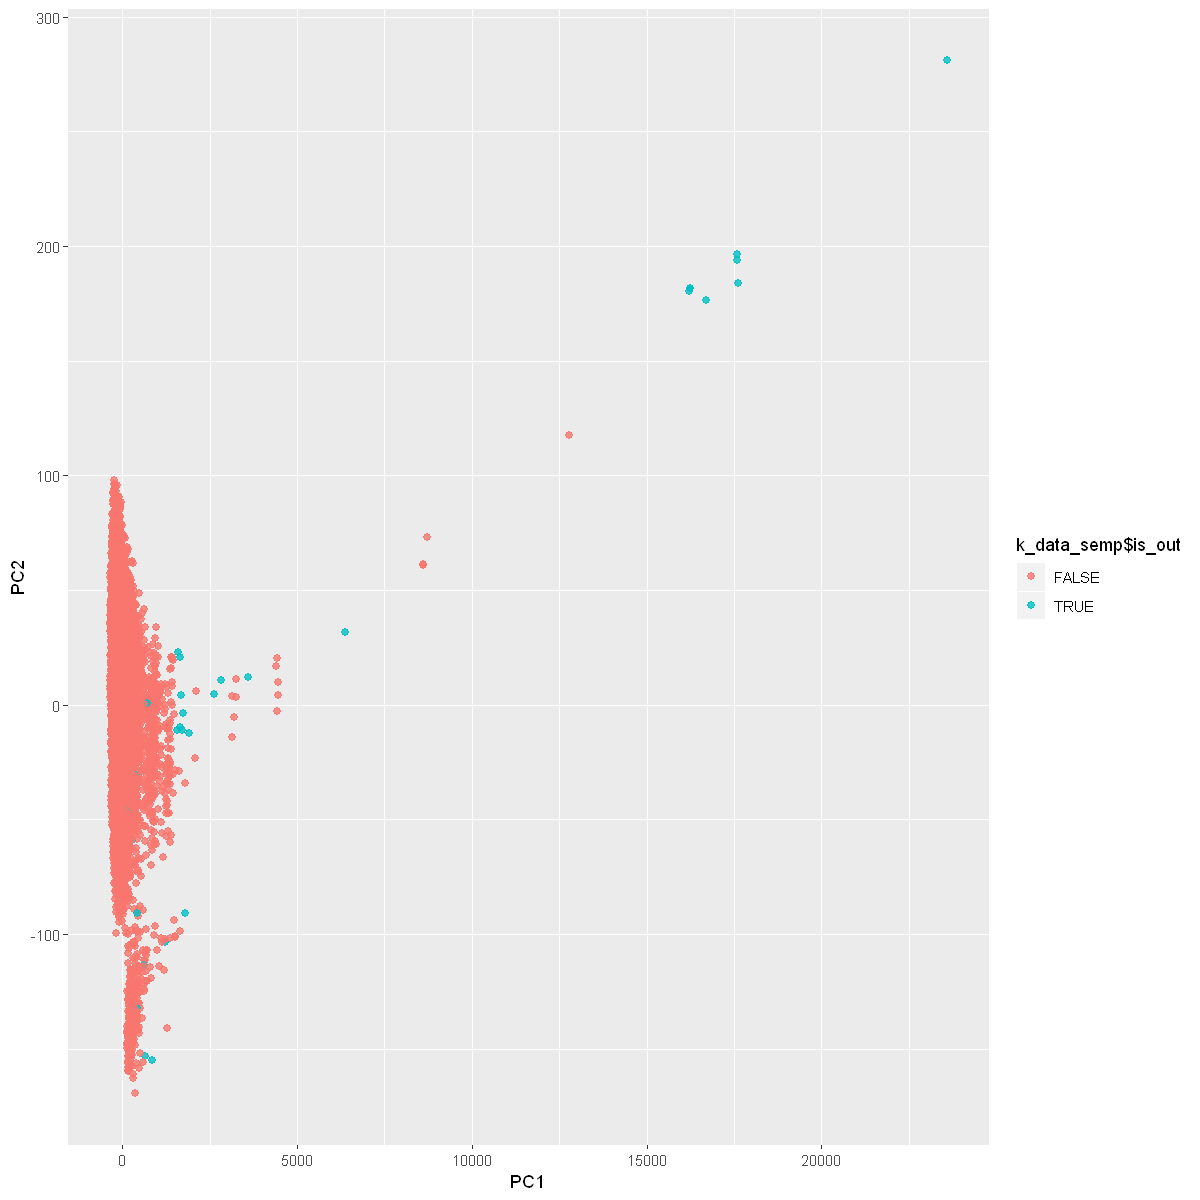

In [172]:
#embedding[, DClusters := mod$k_data_semp]
ggplot(embedding, aes(x = PC1, y = PC2)) +
    geom_point(aes(colour = k_data_semp$is_out), size = 2, alpha = 0.8) 

In [173]:
#remove the support tag
k_data$cluster<-NULL

It is nice to have a look on some of the outliers details

In [174]:
head(k[k_data$is_out,])

,verification_status,issue_d,pymnt_plan,purpose,initial_list_status,emp_length,loan_amnt,funded_amnt,funded_amnt_inv,term,...,annual_inc_rt,inc_grp,revol_bal_rt,credit_hist_log,credit_hist_rt,credit_hist_grp,max_L,max_fund_L,MAX_fund_L_inv,is_acc_now_delinq_not_zero
12,Not Verified,2007-08-01,0,credit_card,1,< 1 year,5000,5000,1300.000,0,...,264.5751,middle_inc,28.51315,3.367296,5.385165,>21_yrs,0,0,0,0
16,Not Verified,2007-08-01,0,credit_card,1,< 1 year,5000,5000,750.000,0,...,316.2278,high_inc,97.47307,2.639057,3.741657,13-17_yrs,0,0,0,0
30,Not Verified,2007-12-01,0,other,1,< 1 year,1000,1000,875.000,0,...,346.4102,high_inc,47.19110,NA,NA,NA,0,0,0,0
31,Not Verified,2007-12-01,0,home_improvement,1,5 years,25000,25000,3824.994,0,...,591.6080,veryhigh_inc,211.72388,2.995732,4.472136,17-21_yrs,0,0,0,0
33,Not Verified,2007-08-01,0,other,1,< 1 year,4000,4000,1925.000,0,...,316.2278,high_inc,90.30504,2.079442,2.828427,4-13_yrs,0,0,0,0
35,Not Verified,2007-07-01,0,small_business,1,< 1 year,10000,10000,400.000,0,...,165.4569,verylow_inc,59.44746,1.945910,2.645751,4-13_yrs,0,0,0,0


<b>To drop or not to drop?</b>
<br>we checked if there is a relation between the "defaulted" variable, which is our outcome variable, to the is_out variable. 
<br>Meaning if there is a correlation between the outliers and the outcome variable




In [175]:
##chi-sqared test
chisq.test(k_data$is_out,k$default, correct=F )


	Pearson's Chi-squared test

data:  k_data$is_out and k$default
X-squared = 2.7631, df = 1, p-value = 0.09646


There is no sagnificant correlation beween the is_out variable and the default variable. but it is not so far from being significant.


second we checked if the relationship between the defaulted variable and the outcome variable did changed as a consequance of the outliers.

In [176]:
#model <- glm(default.1~.,family=binomial,data=k_data_in)
#saveRDS(object = model, file = "log_data_in.rds")
model_in<-readRDS(file = paste0(getwd(),"/Models/log_data_in.rds"))

In [178]:
head(coef(summary(model_in)))
print(paste0("There is ",sum(coef(summary(model_in))[,4]<0.05)," significant variables"))

,Estimate,Std. Error,z value,Pr(>|z|)
(Intercept),2.656606e+01,1.611823e+08,1.648200e-07,0.9999999
loan_amnt,1.589383e-13,1.189894e+04,1.335735e-17,1.0000000
funded_amnt,-8.778217e-12,1.353389e+04,-6.486101e-16,1.0000000
funded_amnt_inv,9.112309e-12,7.142444e+03,1.275797e-15,1.0000000
collections_12_mths_ex_med,3.380840e-09,6.395216e+09,5.286514e-19,1.0000000
mths_since_last_major_derog,1.260288e-14,8.715730e+02,1.445992e-17,1.0000000


[1] "There is 0 significant variables"


we can see that there is no variables with significant correlation with the outcome variable, in the data set with no outliers

In [179]:
#model <- glm(default.1~.,family=binomial,data=k_data)
#saveRDS(object = model, file = "log_data_with_outs.rds")
model_with_out<-readRDS(file = paste0(getwd(),"/Models/log_data_with_outs.rds"))

In [180]:
head(coef(summary(model_with_out)))
print(paste0("There is ",sum(coef(summary(model_with_out))[,4]<0.05)," significant variables"))

,Estimate,Std. Error,z value,Pr(>|z|)
(Intercept),2.656605e+01,2.269532e+12,1.170552e-11,1
loan_amnt,-8.995688e-14,1.176327e+04,-7.647267e-18,1
funded_amnt,-9.103051e-13,1.327436e+04,-6.857622e-17,1
funded_amnt_inv,9.148260e-13,6.917299e+03,1.322519e-16,1
collections_12_mths_ex_med,-1.140817e-08,6.378817e+09,-1.788447e-18,1
mths_since_last_major_derog,-3.434753e-16,8.694248e+02,-3.950604e-19,1


[1] "There is 0 significant variables"


We can see that there is no variables with significant correlation with the outcome variable, in the whole data set (data set include the outliers), therefore we can conclude that the outliers didn't created any correlation between the outcome variable to the other variables.

In [181]:
#model <- glm(default.1~.,family=binomial,data=k_data_outs)
#saveRDS(object = model, file = "log_data_out.rds")
model_out<-readRDS(file = paste0(getwd(),"/Models/log_data_out.rds"))

In [182]:
head(coef(summary(model_out)))
print(paste0("There is ",sum(coef(summary(model_out))[,4]<0.05)," significant variables"))

,Estimate,Std. Error,z value,Pr(>|z|)
(Intercept),2.401748e+01,2.632347e+13,9.123979e-13,1
loan_amnt,1.108727e-08,1.032395e+05,1.073937e-13,1
funded_amnt,-9.614516e-09,8.297735e+04,-1.158692e-13,1
funded_amnt_inv,4.051702e-09,3.329308e+04,1.216980e-13,1
collections_12_mths_ex_med,1.716547e-02,9.742388e+10,1.761936e-13,1
mths_since_last_major_derog,5.866027e-10,1.574257e+04,3.726219e-14,1


[1] "There is 0 significant variables"


we  also can see that there is no variables with significant correlation with the outcome variable, in the data set with just the outliers

For this reasons, we decided to exclude the outliers from the dataset

In [ ]:
dim(k)

In [ ]:
sum(k_data$is_out)

In [ ]:
k_ex<-k[!k_data$is_out,]

In [ ]:
dim(k_ex)

In [ ]:
loans<-k_ex

In [ ]:
##saving table
writeSQL(loans, "loans_dataset_outliers")